In [3]:
import os

file_path = "ethiomart_task2_labeled.conll"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"‚ùå File not found: {file_path}")

tokens, tags = read_conll(file_path)

In [4]:
import os

file_path = os.path.join(os.getcwd(), "ethiomart_task2_labeled.conll")

if not os.path.exists(file_path):
    raise FileNotFoundError(f"‚ùå File not found: {file_path}")

tokens, tags = read_conll(file_path)

In [5]:
# Step 1: Imports
import os
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Step 2: Helper to read CoNLL-formatted data
def read_conll(path):
    sentences = []
    labels = []
    sentence = []
    label = []

    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                if sentence:
                    sentences.append(sentence)
                    labels.append(label)
                    sentence = []
                    label = []
                continue
            token, tag = line.split()
            sentence.append(token)
            label.append(tag)

    if sentence:  # add last sentence if file does not end in a blank line
        sentences.append(sentence)
        labels.append(label)

    return sentences, labels

# Step 3: Load labeled file
file_path = "ethiomart_task2_labeled.conll"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"‚ùå File not found: {file_path}")

tokens, tags = read_conll(file_path)

# Step 4: Create HuggingFace Dataset object
data = {"tokens": tokens, "ner_tags": tags}
dataset = Dataset.from_dict(data)

# Step 5: Train/Test Split
dataset_dict = DatasetDict({
    "train": dataset.train_test_split(test_size=0.2, seed=42)["train"],
    "test": dataset.train_test_split(test_size=0.2, seed=42)["test"]
})

# Step 6: Confirm structure
print(dataset_dict)
print("‚úÖ Task 3 complete: Dataset ready for training")

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 28
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 7
    })
})
‚úÖ Task 3 complete: Dataset ready for training


In [7]:
from datasets import Dataset, DatasetDict

data = {"tokens": tokens, "ner_tags": tags}
dataset = Dataset.from_dict(data)
dataset_dict = dataset.train_test_split(test_size=0.2, seed=42)
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 28
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 7
    })
})


In [8]:
print(dataset_dict["train"][0])


{'tokens': ['Nike', 'infinity', 'flow', 'size', '4041424344', 'Price', '3500', 'birr', '·ä†·ãµ·à´·àª·àú·ä≠·à≤·äÆ', '·äÆ·àú·à≠·àµ', '·åÄ·à≠·â£', '·àò·ãö·ãµ', '·çï·àã·ãõ', '·ã®·àò·åÄ·àò·à™·ã´', '·ã∞·à®·åÉ', '·ä•·äï·ã∞·ãà·å°', '101', '·ã®·â¢·àÆ', '·âÅ·å•·à≠', '·ã´·åà·äô·äì·àç', 'or', 'call', '0920238243', 'EthioBrandhttpstmeethio_brand_collection'], 'ner_tags': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}


In [9]:
assert isinstance(dataset_dict, DatasetDict)
assert all(k in dataset_dict for k in ["train", "test"])

In [10]:
dataset_dict.save_to_disk("data/fine_tune_ready")


Saving the dataset (0/1 shards):   0%|          | 0/28 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7 [00:00<?, ? examples/s]

In [11]:
tokens, tags = read_conll("ethiomart_task2_labeled.conll")


In [12]:
from datasets import load_from_disk

# Load the saved train/test dataset
dataset_dict = load_from_disk("data/fine_tune_ready")

# Confirm structure
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 28
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 7
    })
})


In [13]:
print(dataset_dict["train"][0])


{'tokens': ['Nike', 'infinity', 'flow', 'size', '4041424344', 'Price', '3500', 'birr', '·ä†·ãµ·à´·àª·àú·ä≠·à≤·äÆ', '·äÆ·àú·à≠·àµ', '·åÄ·à≠·â£', '·àò·ãö·ãµ', '·çï·àã·ãõ', '·ã®·àò·åÄ·àò·à™·ã´', '·ã∞·à®·åÉ', '·ä•·äï·ã∞·ãà·å°', '101', '·ã®·â¢·àÆ', '·âÅ·å•·à≠', '·ã´·åà·äô·äì·àç', 'or', 'call', '0920238243', 'EthioBrandhttpstmeethio_brand_collection'], 'ner_tags': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']}


In [14]:
label_list = list(set(label for sublist in dataset_dict["train"]["ner_tags"] for label in sublist))
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in enumerate(label_list)}

In [15]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_checkpoint = "Davlan/afro-xlmr-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list), id2label=id2label, label2id=label2id)

tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--Davlan--afro-xlmr-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
print(dataset_dict["train"][0]["ner_tags"])
print(type(dataset_dict["train"][0]["ner_tags"]))

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
<class 'list'>


In [19]:
# Create label list from dataset and build label2id mapping
label_list = list(set(tag for tags in dataset_dict["train"]["ner_tags"] for tag in tags))
label2id = {label: idx for idx, label in enumerate(sorted(label_list))}
id2label = {idx: label for label, idx in label2id.items()}

In [20]:
def normalize_labels(example):
    example["ner_tags"] = [label2id[tag] for tag in example["ner_tags"]]
    return example

In [21]:
dataset_dict = dataset_dict.map(normalize_labels)


Map:   0%|          | 0/28 [00:00<?, ? examples/s]

Map:   0%|          | 0/7 [00:00<?, ? examples/s]

In [2]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./ner-model",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs"
)

In [3]:
evaluation_strategy="epoch",
logging_steps=10,

In [2]:
import transformers
print(transformers.__version__)

4.52.4


In [1]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./ner-model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [2]:
import os
print(os.path.exists("data/fine_tune_ready"))
print(os.listdir("data") if os.path.exists("data") else "data/ folder not found")

True
['fine_tune_ready']


In [7]:
def read_conll(path):
    sentence = []
    label = []
    sentences = []
    labels = []

    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                if sentence:
                    sentences.append(sentence)
                    labels.append(label)
                    sentence = []
                    label = []
            else:
                splits = line.split()
                if len(splits) >= 2:
                    sentence.append(splits[0])
                    label.append(splits[-1])
    return sentences, labels


In [10]:
import os
print(os.getcwd())

c:\Users\User\OneDrive\Desktop\ethiomart-ner-pipeline\notebooks


In [11]:
tokens, tags = read_conll("ethiomart_task2_labeled.conll")


In [12]:
from datasets import Dataset, DatasetDict

data = {"tokens": tokens, "ner_tags": tags}
dataset = Dataset.from_dict(data)
dataset_dict = dataset.train_test_split(test_size=0.2, seed=42)

In [13]:
label_list = list(set(tag for tags in dataset_dict["train"]["ner_tags"] for tag in tags))
label_list.sort()
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

def normalize_labels(example):
    example["ner_tags"] = [label2id[tag] for tag in example["ner_tags"]]
    return example

dataset_dict = dataset_dict.map(normalize_labels)

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Map:   0%|          | 0/7 [00:00<?, ? examples/s]

In [16]:
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(
        example["tokens"], truncation=True, is_split_into_words=True
    )
    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(int(example["ner_tags"][word_idx]))  # Cast to int
        else:
            labels.append(int(example["ner_tags"][word_idx]))
        previous_word_idx = word_idx

    # ‚úÖ Debugging output inside function
    print("tokens:", example["tokens"])
    print("word_ids:", word_ids)
    print("aligned labels:", labels)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [18]:
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(
        example["tokens"], truncation=True, is_split_into_words=True
    )
    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(int(example["ner_tags"][word_idx]))
        else:
            labels.append(int(example["ner_tags"][word_idx]))
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [21]:
print(dataset_dict)
print(dataset_dict["train"][0])

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 27
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 7
    })
})
{'tokens': ['Tempered', 'Glass', 'Bakeware', 'TikTok', 'tiktokcommirtteka', 'Telegram', 'tmeMerttEka', '·àà·ãà·ã≥·åÜ·âΩ·ãé', 'forward', '·ã´·ãµ·à≠·åâ'], 'ner_tags': [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]}


In [22]:
label_list = list(set(tag for tags in dataset_dict["train"]["ner_tags"] for tag in tags))
label2id = {label: idx for idx, label in enumerate(sorted(label_list))}
id2label = {idx: label for label, idx in label2id.items()}


In [23]:
def normalize_labels(example):
    example["ner_tags"] = [label2id[tag] for tag in example["ner_tags"]]
    return example

dataset_dict = dataset_dict.map(normalize_labels)

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Map:   0%|          | 0/7 [00:00<?, ? examples/s]

In [24]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Davlan/afro-xlmr-base")

def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(
        example["tokens"], truncation=True, is_split_into_words=True
    )
    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(example["ner_tags"][word_idx])
        else:
            labels.append(example["ner_tags"][word_idx])
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [26]:
for i, example in enumerate(dataset_dict["train"]):
    if not isinstance(example["ner_tags"], list):
        print(f"Row {i} is not a list:", example["ner_tags"])
    elif any(not isinstance(tag, int) for tag in example["ner_tags"]):
        print(f"Row {i} has non-int:", example["ner_tags"])

In [27]:
label_list = list(set(tag for tags in dataset_dict["train"]["ner_tags"] for tag in tags))
label2id = {label: idx for idx, label in enumerate(sorted(label_list))}
id2label = {idx: label for label, idx in label2id.items()}

def normalize_labels(example):
    example["ner_tags"] = [label2id[tag] for tag in example["ner_tags"]]
    return example

dataset_dict = dataset_dict.map(normalize_labels)

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Map:   0%|          | 0/7 [00:00<?, ? examples/s]

In [30]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Ignore special tokens
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)  # or label[word_idx] if same word
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [31]:
print(dataset_dict["train"].column_names)  # Check available columns
print(dataset_dict["train"][0])           # Inspect a sample

['tokens', 'ner_tags']
{'tokens': ['Tempered', 'Glass', 'Bakeware', 'TikTok', 'tiktokcommirtteka', 'Telegram', 'tmeMerttEka', '·àà·ãà·ã≥·åÜ·âΩ·ãé', 'forward', '·ã´·ãµ·à≠·åâ'], 'ner_tags': [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]}


In [32]:
# Correct format for `tokens` column:
["Hello", "world", "!"]  # ‚úÖ List of tokens
"Hello world !"           # ‚ùå Raw string (will fail)

'Hello world !'

In [33]:
small_batch = dataset_dict["train"][:2]  # Test on 2 examples
tokenize_and_align_labels(small_batch)

{'input_ids': [[0, 37446, 56, 297, 95384, 15082, 13, 15876, 19591, 618, 685, 2126, 6448, 277, 4326, 3135, 161, 86026, 808, 282, 30248, 3062, 647, 161, 2237, 5698, 5040, 139624, 29597, 40225, 4463, 35929, 11959, 2], [0, 2356, 205545, 8080, 3493, 15937, 34, 1212, 387, 2357, 616, 927, 83479, 62449, 313, 54003, 80588, 37082, 190, 20847, 7338, 856, 1723, 387, 2357, 4221, 11, 109561, 70, 62805, 24018, 31365, 35958, 190, 170582, 42, 43137, 1062, 427, 594, 2041, 1430, 1257, 47, 63907, 117690, 427, 31365, 136, 616, 86039, 13293, 572, 254, 22, 3033, 611, 1022, 38230, 166615, 2661, 46347, 1363, 23856, 45029, 80111, 72804, 54259, 102198, 91969, 3674, 24018, 51210, 189682, 7, 6, 28814, 33457, 1479, 71867, 297, 24018, 38730, 179519, 2037, 47, 534, 26668, 294, 94831, 2592, 23, 206, 1022, 38230, 166615, 2661, 56811, 49119, 4442, 2839, 616, 2839, 98009, 7, 19914, 113458, 2396, 16291, 208071, 106, 28941, 83010, 541, 47599, 13, 26959, 382, 8359, 104621, 758, 305, 10700, 36812, 7, 21947, 81423, 16505, 209

In [34]:
for i, example in enumerate(dataset_dict["train"]):
    try:
        _ = tokenize_and_align_labels(example)
    except Exception as e:
        print(f"‚ùå Error on row {i}:", e)

‚ùå Error on row 0: 'int' object is not subscriptable
‚ùå Error on row 1: 'int' object is not subscriptable
‚ùå Error on row 2: 'int' object is not subscriptable
‚ùå Error on row 3: 'int' object is not subscriptable
‚ùå Error on row 4: 'int' object is not subscriptable
‚ùå Error on row 5: 'int' object is not subscriptable
‚ùå Error on row 6: 'int' object is not subscriptable
‚ùå Error on row 7: 'int' object is not subscriptable
‚ùå Error on row 8: 'int' object is not subscriptable
‚ùå Error on row 9: 'int' object is not subscriptable
‚ùå Error on row 10: 'int' object is not subscriptable
‚ùå Error on row 11: 'int' object is not subscriptable
‚ùå Error on row 12: 'int' object is not subscriptable
‚ùå Error on row 13: 'int' object is not subscriptable
‚ùå Error on row 14: 'int' object is not subscriptable
‚ùå Error on row 15: 'int' object is not subscriptable
‚ùå Error on row 16: 'int' object is not subscriptable
‚ùå Error on row 17: 'int' object is not subscriptable
‚ùå Error on row 18:

In [36]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    
    # Initialize labels list
    labels = []
    
    # Check if labels are already sequences
    if isinstance(examples["ner_tags"][0], int):
        # Single label case - convert to list of lists
        label_sequences = [[tag] for tag in examples["ner_tags"]]
    else:
        label_sequences = examples["ner_tags"]
    
    for i, label_seq in enumerate(label_sequences):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Special tokens
            elif word_idx != previous_word_idx:
                label_ids.append(label_seq[word_idx])
            else:
                label_ids.append(-100)  # Or label_seq[word_idx] if same word
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [37]:
broken_indices = []
for i, example in enumerate(dataset_dict["train"]):
    try:
        _ = tokenize_and_align_labels({k: [v] for k, v in example.items()})
    except Exception as e:
        print(f"Error on row {i}:", e)
        broken_indices.append(i)

In [39]:
# First identify all broken rows
broken_indices = []
for i in range(len(dataset_dict["train"])):
    try:
        # Test if the row can be processed
        example = dataset_dict["train"][i]
        _ = tokenize_and_align_labels({"tokens": [example["tokens"]], "ner_tags": [example["ner_tags"]]})
    except Exception as e:
        broken_indices.append(i)
        print(f"Broken row {i}: {str(e)}")

# Then filter them out
if broken_indices:
    dataset_dict["train"] = dataset_dict["train"].select(
        [i for i in range(len(dataset_dict["train"])) 
        if i not in broken_indices]
    )
    print(f"Removed {len(broken_indices)} broken rows")
else:
    print("No broken rows found")

No broken rows found


In [40]:
# First identify all broken rows
broken_indices = []

for i in range(len(dataset_dict["train"])):
    try:
        example = dataset_dict["train"][i]
        # Properly format the input as a dictionary
        _ = tokenize_and_align_labels({"tokens": [example["tokens"]], "ner_tags": [example["ner_tags"]]})
    except Exception as e:
        broken_indices.append(i)
        print(f"Broken row {i}: {str(e)}")  # Fixed string formatting

# Then filter them out
if broken_indices:
    dataset_dict["train"] = dataset_dict["train"].select(  # Fixed period to dot
        [i for i in range(len(dataset_dict["train"])) 
        if i not in broken_indices]
    )
    print(f"Removed {len(broken_indices)} broken rows")  # Fixed string formatting
else:
    print("No broken rows found")

No broken rows found


In [41]:
def debug_tokenize(example):
    print("Input tokens:", example["tokens"])
    print("Input tags:", example["ner_tags"])
    print("Type of tags:", type(example["ner_tags"]))
    # Rest of your function...

In [42]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

models = {
    "xlm-roberta": "xlm-roberta-base",
    "afroxlmr": "castorini/afroxlmr-large", 
    "mbert": "bert-base-multilingual-cased",
    "amharic-bert": "Davlan/bert-base-multilingual-cased-finetuned-amharic"
}

In [44]:
from seqeval.metrics import classification_report
import numpy as np

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = classification_report(true_labels, true_predictions, output_dict=True)
    return {
        "precision": results["weighted avg"]["precision"],
        "recall": results["weighted avg"]["recall"],
        "f1": results["weighted avg"]["f1-score"],
        "accuracy": results["accuracy"]
    }

In [48]:
import transformers
import datasets
print(f"Transformers version: {transformers.__version__}")
print(f"Datasets version: {datasets.__version__}")
# Should output versions ‚â•4.30.0 for full compatibility

Transformers version: 4.30.2
Datasets version: 2.12.0


In [52]:
import sys
print(sys.executable)  # Verify you're using the right Python

c:\Users\User\AppData\Local\Programs\Python\Python311\python.exe


In [53]:
import transformers
print(transformers.__version__)  # Should print version (4.30+ recommended)

4.30.2


In [56]:
for i, example in enumerate(dataset_dict["train"]):
    if not isinstance(example, dict) or "tokens" not in example or "ner_tags" not in example:
        print(f"‚ùå Row {i} is broken:", example)

In [57]:
good_indices = [
    i for i, example in enumerate(dataset_dict["train"])
    if isinstance(example, dict) and "tokens" in example and "ner_tags" in example
]

In [58]:
dataset_dict["train"] = dataset_dict["train"].select(good_indices)

In [59]:
tokenized_dataset = dataset_dict.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Map:   0%|          | 0/7 [00:00<?, ? examples/s]

In [60]:
tokenized_dataset = dataset_dict.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Map:   0%|          | 0/7 [00:00<?, ? examples/s]

In [1]:
from transformers import Trainer


In [3]:
import transformers
print(transformers.__version__)

4.52.4


In [2]:
import transformers
print(transformers.__version__)

4.52.4


In [1]:
import transformers
print(transformers.__version__)

4.40.0


In [2]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./ner-model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

In [3]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./ner-model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

In [2]:
tokens, tags = read_conll("ethiomart_task2_labeled.conll")


In [3]:
import os

current_dir = os.path.dirname(__file__) if "__file__" in globals() else os.getcwd()
file_path = os.path.join(current_dir, "ethiomart_task2_labeled.conll")
tokens, tags = read_conll(file_path)

In [4]:
print(tokens[0])
print(tags[0])

['BABY', 'SWADDLING', 'BLANKETS', '·ã®·å®·âÖ·àã', '·àÖ·çÉ·äì·âµ', '·àõ·âÄ·çä·ã´·äì', '·àõ·àµ·â∞·äõ', '·â•·à≠·ãµ', '·àç·â•·àµ', '·ä†·ã≤·àµ', '·àà·â∞·ãà·àà·ã±', '·ä•·äì', '·ä•·àµ·ä®', '6·ãà·à≠', '·àã·àâ', '·àÖ·çÉ·äì·âµ', '·ã®·àö·àÜ·äï', '·â†·å£·àù', '·ãà·çç·à´·àù', '·àà·àµ·àã·à≥', '·àÖ·çÉ·äì·âµ', '·ä•·äì', '·ä•·äì·â∂·âΩ', '·ã®·àö·àò·à≠·å°·âµ', '·ãã·åã', '1800', '·â•·à≠', '·â†·â¥·àå·åç·à´·àù', '·àà·àõ·ãò·ãù', 'awasadmin1', 'awasadmin2', '·ä†·ãµ·à´·àª·âΩ·äï', '1', '·àú·ä≠·à≤·äÆ', '·ä†·àç·à≥·àù', '·ä†·çì·à≠·â≥·àõ', '·åç·à´·ãç·äï·ãµ', '·âÅ', '29', '2', '·â¶·àå', '·àò·ãµ·àê·äî·ãì·àà·àù', '·â¶·àå', '·àò·à∞·äì·ã∂', '·âµ·â§·âµ', '·çä·âµ·àà·çä·âµ', '·ä†·àà·àù·äê·àΩ', '·çï·àã·ãõ', '·åç·à´·ãç·äï·ãµ', '·à±·âÖ', '·âÅ·å•·à≠', '05', '251941661030', '251943190237', '·àà·ãà·ã≥·åÖ·ãé', '·àµ·àã·åã·à©', '·ä•·äì·àò·à†·åç·äì·àà·äï', '·â¥·àå·åç·à´·àù', '·âª·äì·àç', 'tmeAwasMart']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PRICE', 'O', 'B-LOCATION', 'O', 'O', 'B-PRICE', 'O', 'O', 'O', 'O', 'B-PRICE', 'O', 'O', 'O',

In [5]:
data = {"tokens": tokens, "ner_tags": tags}


In [6]:
label_list = sorted(set(tag for seq in tags for tag in seq))
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for label, i in label2id.items()}

In [8]:
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# Split data
train_tokens, test_tokens, train_tags, test_tags = train_test_split(tokens, tags, test_size=0.2, random_state=42)

# Create DatasetDict
train_dataset = Dataset.from_dict({"tokens": train_tokens, "ner_tags": train_tags})
test_dataset = Dataset.from_dict({"tokens": test_tokens, "ner_tags": test_tags})
dataset_dict = DatasetDict({"train": train_dataset, "test": test_dataset})

In [9]:
def normalize_labels(example):
    example["ner_tags"] = [label2id[tag] for tag in example["ner_tags"]]
    return example

dataset_dict = dataset_dict.map(normalize_labels)

Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Map:   0%|          | 0/7 [00:00<?, ? examples/s]

In [10]:
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], 
                                  truncation=True, 
                                  is_split_into_words=True)
    
    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None
    
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(example["ner_tags"][word_idx])
        else:
            labels.append(-100)
        previous_word_idx = word_idx
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [13]:
from transformers import AutoTokenizer

model_checkpoint = "Davlan/afro-xlmr-base"  # Or any model you're using
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [14]:
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], 
                                 truncation=True, 
                                 is_split_into_words=True)
    
    labels = []
    word_ids = tokenized_inputs.word_ids()
    previous_word_idx = None
    
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        elif word_idx != previous_word_idx:
            labels.append(example["ner_tags"][word_idx])
        else:
            labels.append(-100)
        previous_word_idx = word_idx
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [16]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"],
                                 truncation=True,
                                 is_split_into_words=True)

    labels_batch = []
    for i, word_ids in enumerate(tokenized_inputs.word_ids(batch_index=i) for i in range(len(examples["tokens"]))):
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(examples["ner_tags"][i][word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels_batch.append(label_ids)

    tokenized_inputs["labels"] = labels_batch
    return tokenized_inputs

In [17]:
tokenized_dataset = dataset_dict.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Map:   0%|          | 0/7 [00:00<?, ? examples/s]

In [18]:
tokenized_dataset["train"][0]


{'tokens': ['·ãâ·àÉ',
  '·àµ·à≠·åà·âµ·äï',
  '·ãà·ã∞',
  '·çç·à´·àΩ',
  '·ãâ·àµ·å•',
  '·ä•·äï·ã≥·ã≠·åà·â£',
  '·ä•·äì',
  '·ä†·àã·àµ·çà·àã·åä',
  '·àΩ·â≥·äï',
  '·ä•·äï·ã≤·àÅ·àù',
  '·ãµ·ä´·àù·äï',
  '·ã®·àö·ä®·àã·ä®·àç',
  '·ä†·äï·à∂·àã',
  'Mattress',
  'PROTECTOR',
  'POLYESTER',
  'MICROFIBER',
  '·àà',
  '150',
  '·àà',
  '180',
  '·ä®·äê·çÉ',
  '·ã≤·àä·â®·à™',
  '·åã·à≠',
  '3500',
  '·â•·à≠',
  '·ä†·ãµ·à´·àª',
  '·âÅ·å•·à≠',
  '1',
  '·àç·ã∞·â≥',
  '·ãà·ã∞',
  '·â£·àç·âª',
  '·àÜ·àµ·çí·â≥·àç',
  '·åà·â£',
  '·â•·àé',
  '·ä†·àÖ·àò·ãµ',
  '·àÖ·äï·çÉ',
  '·àã·ã≠',
  '1·äõ·çé·âÖ',
  '114B',
  '·â£·àâ·â†·âµ',
  '·ã´·àà·â∞·å®·àõ·à™',
  '·ä≠·çç·ã´',
  '·àõ·ãò·ãù',
  '·ã≠·âΩ·àã·àâ',
  '0933334444',
  'LeMazez_z',
  '0946242424',
  'Le_Mazez',
  '0944109295',
  'Lemaze_z'],
 'ner_tags': [3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  1,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  1,
  3,
  3,
  3,
  1,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  1,

In [19]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at Davlan/afro-xlmr-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
training_args = TrainingArguments(
    output_dir="./ner-model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
)

In [23]:
tokenized_dataset["train"][0]["labels"]


[-100,
 3,
 -100,
 -100,
 3,
 -100,
 -100,
 3,
 3,
 -100,
 3,
 3,
 -100,
 3,
 3,
 -100,
 -100,
 3,
 -100,
 3,
 3,
 -100,
 -100,
 1,
 -100,
 -100,
 3,
 -100,
 -100,
 3,
 -100,
 3,
 -100,
 -100,
 3,
 -100,
 -100,
 3,
 -100,
 -100,
 -100,
 -100,
 3,
 3,
 3,
 3,
 1,
 -100,
 3,
 -100,
 -100,
 -100,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 -100,
 -100,
 3,
 3,
 -100,
 3,
 3,
 -100,
 3,
 3,
 3,
 -100,
 -100,
 3,
 3,
 -100,
 -100,
 -100,
 3,
 -100,
 1,
 -100,
 -100,
 3,
 -100,
 -100,
 -100,
 3,
 3,
 -100,
 -100,
 3,
 3,
 -100,
 -100,
 -100,
 3,
 -100,
 -100,
 -100,
 -100,
 -100,
 3,
 -100,
 -100,
 -100,
 -100,
 3,
 -100,
 -100,
 -100,
 -100,
 3,
 -100,
 -100,
 -100,
 -100,
 3,
 -100,
 -100,
 -100,
 -100,
 -100]

In [25]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"],
                                 truncation=True,
                                 is_split_into_words=True,
                                 padding="max_length")

    all_labels = []
    for i, word_ids in enumerate(tokenized_inputs.word_ids(batch_index=i) for i in range(len(examples["tokens"]))):
        labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                labels.append(-100)
            elif word_idx != previous_word_idx:
                labels.append(examples["ner_tags"][i][word_idx])
            else:
                labels.append(-100)
            previous_word_idx = word_idx
        all_labels.append(labels)

    tokenized_inputs["labels"] = all_labels

    # Force conversion to plain dict of lists (not BatchEncoding or tensors)
    return {k: v for k, v in tokenized_inputs.items()}

In [26]:
tokenized_dataset = dataset_dict.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Map:   0%|          | 0/7 [00:00<?, ? examples/s]

In [27]:
tokenized_dataset["train"][0]["labels"]


[-100,
 3,
 -100,
 -100,
 3,
 -100,
 -100,
 3,
 3,
 -100,
 3,
 3,
 -100,
 3,
 3,
 -100,
 -100,
 3,
 -100,
 3,
 3,
 -100,
 -100,
 1,
 -100,
 -100,
 3,
 -100,
 -100,
 3,
 -100,
 3,
 -100,
 -100,
 3,
 -100,
 -100,
 3,
 -100,
 -100,
 -100,
 -100,
 3,
 3,
 3,
 3,
 1,
 -100,
 3,
 -100,
 -100,
 -100,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 -100,
 -100,
 3,
 3,
 -100,
 3,
 3,
 -100,
 3,
 3,
 3,
 -100,
 -100,
 3,
 3,
 -100,
 -100,
 -100,
 3,
 -100,
 1,
 -100,
 -100,
 3,
 -100,
 -100,
 -100,
 3,
 3,
 -100,
 -100,
 3,
 3,
 -100,
 -100,
 -100,
 3,
 -100,
 -100,
 -100,
 -100,
 -100,
 3,
 -100,
 -100,
 -100,
 -100,
 3,
 -100,
 -100,
 -100,
 -100,
 3,
 -100,
 -100,
 -100,
 -100,
 3,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100

In [29]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"],
                                 truncation=True,
                                 is_split_into_words=True,
                                 padding="max_length",
                                 return_tensors=None)  # <- Do NOT return tensors here

    all_labels = []
    for i, word_ids in enumerate(tokenized_inputs.word_ids(batch_index=i) for i in range(len(examples["tokens"]))):
        labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                labels.append(-100)
            elif word_idx != previous_word_idx:
                labels.append(examples["ner_tags"][i][word_idx])
            else:
                labels.append(-100)
            previous_word_idx = word_idx
        all_labels.append(labels)

    tokenized_inputs["labels"] = all_labels

    # ‚õî Do NOT wrap with dict comprehension
    return tokenized_inputs  # Must remain a BatchEncoding with list values

In [30]:
tokenized_dataset = dataset_dict.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Map:   0%|          | 0/7 [00:00<?, ? examples/s]

In [32]:
tokenized_dataset["train"].features


{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [35]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding="max_length",  # ensure uniform length
        is_split_into_words=True
    )

    all_labels = []
    for i, word_ids in enumerate(tokenized_inputs.word_ids(batch_index=i) for i in range(len(examples["tokens"]))):
        labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                labels.append(-100)
            elif word_idx != previous_word_idx:
                labels.append(examples["ner_tags"][i][word_idx])
            else:
                labels.append(-100)
            previous_word_idx = word_idx
        all_labels.append(labels)

    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

In [36]:
tokenized_dataset = dataset_dict.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Map:   0%|          | 0/7 [00:00<?, ? examples/s]

In [37]:
len(tokenized_dataset["train"][0]["labels"]) == len(tokenized_dataset["train"][0]["input_ids"])  # should be True


True

In [39]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding="max_length",
        is_split_into_words=True
    )

    all_labels = []
    for i, word_ids in enumerate(tokenized_inputs.word_ids(batch_index=i) for i in range(len(examples["tokens"]))):
        labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                labels.append(-100)
            elif word_idx != previous_word_idx:
                labels.append(examples["ner_tags"][i][word_idx])
            else:
                labels.append(-100)
            previous_word_idx = word_idx
        all_labels.append(labels)

    # ‚úÖ Ensure all are int64-compatible
    tokenized_inputs["input_ids"] = [[int(x) for x in seq] for seq in tokenized_inputs["input_ids"]]
    tokenized_inputs["attention_mask"] = [[int(x) for x in seq] for seq in tokenized_inputs["attention_mask"]]
    tokenized_inputs["labels"] = [[int(x) for x in seq] for seq in all_labels]

    return tokenized_inputs

In [40]:
tokenized_dataset = dataset_dict.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Map:   0%|          | 0/7 [00:00<?, ? examples/s]

In [42]:
print(tokenized_dataset["train"].features)


{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'ner_tags': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}


In [43]:
def tokenize_and_align_labels(examples):
    max_length = 128  # fixed value for input length

    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding="max_length",
        max_length=max_length,
        is_split_into_words=True
    )

    all_labels = []
    for i, word_ids in enumerate(tokenized_inputs.word_ids(batch_index=i) for i in range(len(examples["tokens"]))):
        labels = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                labels.append(-100)
            elif word_idx != previous_word_idx:
                labels.append(examples["ner_tags"][i][word_idx])
            else:
                labels.append(-100)
            previous_word_idx = word_idx

        # ‚úÖ Ensure label length == max_length
        labels += [-100] * (max_length - len(labels))  # pad manually
        labels = labels[:max_length]  # truncate if longer
        all_labels.append(labels)

    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs


In [44]:
tokenized_dataset = dataset_dict.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Map:   0%|          | 0/7 [00:00<?, ? examples/s]

In [45]:
print(len(tokenized_dataset["train"][0]["input_ids"]))
print(len(tokenized_dataset["train"][0]["labels"]))

128
128


In [47]:
tokenized_dataset = tokenized_dataset.remove_columns(["tokens", "ner_tags"])


In [49]:
tokenized_dataset["train"].features


{'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [51]:
from torch.utils.data import DataLoader

batch = next(iter(DataLoader(tokenized_dataset["train"], batch_size=2)))
print(batch)

{'input_ids': [tensor([0, 0]), tensor([6, 6]), tensor([12131, 35772]), tensor([12611, 48064]), tensor([62215, 17733]), tensor([154659,  29597]), tensor([548,   6]), tensor([ 5156, 14414]), tensor([29831,  5653]), tensor([162796,   2269]), tensor([186706,  31867]), tensor([58156, 64019]), tensor([21080, 66890]), tensor([2302,    6]), tensor([57639, 34902]), tensor([2095, 1437]), tensor([210899,  44228]), tensor([86838, 11959]), tensor([145545, 135234]), tensor([42262,     6]), tensor([60757, 49187]), tensor([6393, 3639]), tensor([ 43205, 176354]), tensor([  2627, 131005]), tensor([177117,  79082]), tensor([2202, 1464]), tensor([20924,  6839]), tensor([21554,  5495]), tensor([4712, 4585]), tensor([  7656, 114820]), tensor([87463,   101]), tensor([185211,      6]), tensor([   441, 204198]), tensor([27010, 76094]), tensor([64353, 45196]), tensor([1723,    6]), tensor([205885,  14414]), tensor([   6, 6550]), tensor([135775,  23374]), tensor([ 14255, 122648]), tensor([22724,  1437]), tensor(

In [52]:
print(tokenized_dataset["train"].format)


{'type': None, 'format_kwargs': {}, 'columns': ['input_ids', 'attention_mask', 'labels'], 'output_all_columns': False}


In [54]:
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


In [55]:
print(tokenized_dataset["train"].format)


{'type': 'torch', 'format_kwargs': {}, 'columns': ['input_ids', 'attention_mask', 'labels'], 'output_all_columns': False}


In [57]:
from torch.utils.data import DataLoader

dl = DataLoader(tokenized_dataset["train"], batch_size=2)
batch = next(iter(dl))
print(batch)

{'input_ids': tensor([[     0,      6,  12131,  12611,  62215, 154659,    548,   5156,  29831,
         162796, 186706,  58156,  21080,   2302,  57639,   2095, 210899,  86838,
         145545,  42262,  60757,   6393,  43205,   2627, 177117,   2202,  20924,
          21554,   4712,   7656,  87463, 185211,    441,  27010,  64353,   1723,
         205885,      6, 135775,  14255,  22724,  24480,   2237,   3252,   2237,
           8719, 124404,  29307,  99177,  12354, 241520,   7423,   7280,  97977,
          35648, 140042,  61264,    106,  19730,   4555,   3348,   5156,  93076,
          17231, 237552,      6,  21080,  27231, 115798,      6,  49334,  29307,
           2269,    106,   9171,  31531,   5653,  44909,    571,      6,  66619,
           4088,  16863,   4413,  16333, 124449, 206852,   4363,   9039,   7872,
          94164,   3894,  66000,  10289,  88471,    636,   4613,    731,    169,
            454,    169,   3894,   9271,   2357,   2357,   2357,    636,    454,
           461

In [58]:
for key in batch:
    print(key, type(batch[key]), batch[key].shape)

input_ids <class 'torch.Tensor'> torch.Size([2, 128])
attention_mask <class 'torch.Tensor'> torch.Size([2, 128])
labels <class 'torch.Tensor'> torch.Size([2, 128])


In [59]:
def is_valid(example):
    return (
        len(example["input_ids"]) == 128 and
        len(example["attention_mask"]) == 128 and
        len(example["labels"]) == 128 and
        all(isinstance(i, int) for i in example["labels"])
    )

tokenized_dataset = tokenized_dataset.filter(is_valid)

Filter:   0%|          | 0/27 [00:00<?, ? examples/s]

Filter:   0%|          | 0/7 [00:00<?, ? examples/s]

In [60]:
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


In [67]:
def is_valid(example):
    return (
        len(example["input_ids"]) > 0 and
        len(example["attention_mask"]) == len(example["input_ids"]) and
        len(example["labels"]) == len(example["input_ids"]) and
        all(isinstance(i, int) for i in example["labels"])
    )

In [68]:
tokenized_dataset = tokenized_dataset.filter(is_valid)
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
print("Train:", len(tokenized_dataset["train"]))

Train: 0


In [69]:
tokenized_dataset = dataset_dict.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/27 [00:00<?, ? examples/s]

Map:   0%|          | 0/7 [00:00<?, ? examples/s]

In [70]:
print(tokenized_dataset["train"][0]["tokens"])
print(tokenized_dataset["train"][0]["labels"])
print(len(tokenized_dataset["train"][0]["tokens"]), len(tokenized_dataset["train"][0]["labels"]))


['·ãâ·àÉ', '·àµ·à≠·åà·âµ·äï', '·ãà·ã∞', '·çç·à´·àΩ', '·ãâ·àµ·å•', '·ä•·äï·ã≥·ã≠·åà·â£', '·ä•·äì', '·ä†·àã·àµ·çà·àã·åä', '·àΩ·â≥·äï', '·ä•·äï·ã≤·àÅ·àù', '·ãµ·ä´·àù·äï', '·ã®·àö·ä®·àã·ä®·àç', '·ä†·äï·à∂·àã', 'Mattress', 'PROTECTOR', 'POLYESTER', 'MICROFIBER', '·àà', '150', '·àà', '180', '·ä®·äê·çÉ', '·ã≤·àä·â®·à™', '·åã·à≠', '3500', '·â•·à≠', '·ä†·ãµ·à´·àª', '·âÅ·å•·à≠', '1', '·àç·ã∞·â≥', '·ãà·ã∞', '·â£·àç·âª', '·àÜ·àµ·çí·â≥·àç', '·åà·â£', '·â•·àé', '·ä†·àÖ·àò·ãµ', '·àÖ·äï·çÉ', '·àã·ã≠', '1·äõ·çé·âÖ', '114B', '·â£·àâ·â†·âµ', '·ã´·àà·â∞·å®·àõ·à™', '·ä≠·çç·ã´', '·àõ·ãò·ãù', '·ã≠·âΩ·àã·àâ', '0933334444', 'LeMazez_z', '0946242424', 'Le_Mazez', '0944109295', 'Lemaze_z']
[-100, 3, -100, -100, 3, -100, -100, 3, 3, -100, 3, 3, -100, 3, 3, -100, -100, 3, -100, 3, 3, -100, -100, 1, -100, -100, 3, -100, -100, 3, -100, 3, -100, -100, 3, -100, -100, 3, -100, -100, -100, -100, 3, 3, 3, 3, 1, -100, 3, -100, -100, -100, 3, 3, 1, 3, 3, 3, 3, -100, -100, 3, 3, -100, 3, 3, -100, 3, 3, 3, -100, -100, 3, 3, 

In [71]:
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)
    word_ids = tokenized_inputs.word_ids()

    labels = []
    for i, word_idx in enumerate(word_ids):
        if word_idx is None:
            labels.append(-100)
        else:
            labels.append(example["ner_tags"][word_idx])

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


In [72]:
print("Train:", len(tokenized_dataset["train"]))


Train: 27


In [73]:
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])


In [74]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./ner-model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=5,
)


In [76]:
# Reset dataset format again
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Recreate Trainer (must be AFTER set_format)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
)


In [77]:
trainer.train()


  0%|          | 0/42 [00:00<?, ?it/s]

{'loss': 1.0169, 'grad_norm': 5.719838619232178, 'learning_rate': 1.761904761904762e-05, 'epoch': 0.36}
{'loss': 0.7252, 'grad_norm': 3.863450527191162, 'learning_rate': 1.523809523809524e-05, 'epoch': 0.71}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.25271376967430115, 'eval_runtime': 1.6592, 'eval_samples_per_second': 4.219, 'eval_steps_per_second': 2.411, 'epoch': 1.0}
{'loss': 0.4766, 'grad_norm': 1.8696160316467285, 'learning_rate': 1.2857142857142859e-05, 'epoch': 1.07}
{'loss': 0.4915, 'grad_norm': 4.525208950042725, 'learning_rate': 1.0476190476190477e-05, 'epoch': 1.43}
{'loss': 0.2619, 'grad_norm': 2.115431308746338, 'learning_rate': 8.095238095238097e-06, 'epoch': 1.79}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.21657605469226837, 'eval_runtime': 1.8368, 'eval_samples_per_second': 3.811, 'eval_steps_per_second': 2.178, 'epoch': 2.0}
{'loss': 0.4205, 'grad_norm': 3.348238945007324, 'learning_rate': 5.7142857142857145e-06, 'epoch': 2.14}
{'loss': 0.2841, 'grad_norm': 2.4952657222747803, 'learning_rate': 3.3333333333333333e-06, 'epoch': 2.5}
{'loss': 0.3956, 'grad_norm': 1.5027955770492554, 'learning_rate': 9.523809523809525e-07, 'epoch': 2.86}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.20861952006816864, 'eval_runtime': 1.7433, 'eval_samples_per_second': 4.015, 'eval_steps_per_second': 2.294, 'epoch': 3.0}
{'train_runtime': 194.4023, 'train_samples_per_second': 0.417, 'train_steps_per_second': 0.216, 'train_loss': 0.49043726992039455, 'epoch': 3.0}


TrainOutput(global_step=42, training_loss=0.49043726992039455, metrics={'train_runtime': 194.4023, 'train_samples_per_second': 0.417, 'train_steps_per_second': 0.216, 'total_flos': 5291354999808.0, 'train_loss': 0.49043726992039455, 'epoch': 3.0})

In [78]:
trainer.save_model("./ner-model")
tokenizer.save_pretrained("./ner-model")


('./ner-model\\tokenizer_config.json',
 './ner-model\\special_tokens_map.json',
 './ner-model\\tokenizer.json')

In [79]:
from transformers import pipeline

# Load your fine-tuned model and tokenizer
ner_pipeline = pipeline("ner", model="./ner-model", tokenizer="./ner-model", aggregation_strategy="simple")

# Example Amharic text
text = "·ä†·ã≤·àµ ·ä†·â†·â£ ·ãç·àµ·å• ·ä®·â∞·àõ·ãã ·àã·ã≠ ·â†300 ·â•·à≠ ·â§·âµ ·àΩ·ã´·å≠ ·â∞·ä´·àÑ·ã∑·àç·ç¢"

# Run prediction
results = ner_pipeline(text)
for entity in results:
    print(entity)


In [80]:
trainer.evaluate()


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.20861952006816864,
 'eval_runtime': 2.8394,
 'eval_samples_per_second': 2.465,
 'eval_steps_per_second': 1.409,
 'epoch': 3.0}

In [83]:
trainer.save_model("./final_ner_model")
tokenizer.save_pretrained("./final_ner_model")


('./final_ner_model\\tokenizer_config.json',
 './final_ner_model\\special_tokens_map.json',
 './final_ner_model\\tokenizer.json')

In [84]:
from huggingface_hub import login
login()  # Paste your token with write access


In [90]:
from huggingface_hub import login
login()


In [91]:
from transformers import AutoTokenizer

model.push_to_hub("rufeshe/ethio-ner-model")
tokenizer.push_to_hub("rufeshe/ethio-ner-model")

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--rufeshe--ethio-ner-model. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/rufeshe/ethio-ner-model/commit/79ddc3d8aa27d69851a529868c9917cc33ed6131', commit_message='Upload tokenizer', commit_description='', oid='79ddc3d8aa27d69851a529868c9917cc33ed6131', pr_url=None, repo_url=RepoUrl('https://huggingface.co/rufeshe/ethio-ner-model', endpoint='https://huggingface.co', repo_type='model', repo_id='rufeshe/ethio-ner-model'), pr_revision=None, pr_num=None)

In [1]:
from transformers import pipeline

ner_pipeline = pipeline(
    "token-classification",
    model="rufeshe/ethio-ner-model",
    tokenizer="rufeshe/ethio-ner-model",
    aggregation_strategy="simple"
)

result = ner_pipeline("·ä•·âµ·â¶·âΩ ·â†·ä¢·âµ·ãÆ·åµ·ã´ ·äì·â∏·ãç")
print(result)


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:  44%|####3     | 870M/1.98G [00:00<?, ?B/s]

Error while downloading from https://huggingface.co/rufeshe/ethio-ner-model/resolve/main/model.safetensors: HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out.
Trying to resume download...


model.safetensors:  44%|####3     | 870M/1.98G [00:00<?, ?B/s]

Error while downloading from https://huggingface.co/rufeshe/ethio-ner-model/resolve/main/model.safetensors: HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out.
Trying to resume download...


model.safetensors:  48%|####7     | 1.02G/2.13G [00:00<?, ?B/s]

Error while downloading from https://huggingface.co/rufeshe/ethio-ner-model/resolve/main/model.safetensors: HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out.
Trying to resume download...


model.safetensors:  48%|####7     | 1.02G/2.13G [00:00<?, ?B/s]

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--rufeshe--ethio-ner-model. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

[]


In [2]:
from transformers import pipeline

ner_pipeline = pipeline(
    "token-classification",
    model="rufeshe/ethio-ner-model",
    tokenizer="rufeshe/ethio-ner-model",
    aggregation_strategy="simple"
)

result = ner_pipeline("·ä•·äî·àù ·â†·ä†·àõ·à´ ·âã·äï·âã ·ä•·àõ·à´·àà·àÅ")
print(result)


[]


In [3]:
texts = [
    "·ã∂·ä≠·â∞·à≠ ·àò·ä©·à≥ ·â†·ä†·ã≤·àµ ·ä†·â†·â£ ·ã®·àö·äñ·à≠ ·àê·ä™·àù ·äê·ãç·ç¢",
    "·ä¢·âµ·ãÆ·åµ·ã´ ·â†·ä†·çç·à™·ä´ ·àù·à•·à´·âÖ ·ä†·åà·à≠ ·äê·âΩ·ç¢",
    "·à©·çå·à¥ ·â†·à∂·çç·âµ·ãå·à≠ ·ä¢·äï·åÖ·äê·à™·äï·åç ·àã·ã≠ ·à•·à´ ·ä•·ã®·à†·à´ ·äê·ãç·ç¢"
]
for text in texts:
    print(ner_pipeline(text))


[]
[]
[]


In [7]:
from datasets import DatasetDict, load_dataset

dataset_dict = load_dataset("text", data_files={"train": "ethiomart_task2_labeled.conll"})


Generating train split: 0 examples [00:00, ? examples/s]

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("rufeshe/ethio-ner-model")

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    # add logic for aligning ner_tags here
    return tokenized_inputs


In [10]:
from datasets import load_dataset

dataset = load_dataset("text", data_files="ethiomart_task2_labeled.conll")  # adjust to your filename


In [11]:
dataset_dict = DatasetDict({"train": dataset["train"]})


In [13]:
print(dataset_dict)
print(dataset_dict["train"][0])


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1891
    })
})
{'text': 'BABY O'}


In [16]:
def tokenize_and_align_labels(example):
    return tokenizer(example["text"], truncation=True, padding='max_length')


In [17]:
tokenized_dataset = dataset_dict.map(tokenize_and_align_labels, batched=True)


Map:   0%|          | 0/1891 [00:00<?, ? examples/s]

In [18]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [1]:
model_checkpoint = "Davlan/xlm-roberta-base-ner-hrl"


In [1]:
from transformers import pipeline

ner_pipeline = pipeline(
    "token-classification",
    model="rufeshe/ethio-ner-model",
    aggregation_strategy="simple"
)

text = "·ä†·ãã·àµ·àõ·à≠·âµ ·â†·ä†·ã≤·àµ ·à≤·àµ·â∞·àù ·àã·ã≠ ·ä†·ã≥·ã≤·àµ ·àû·ã¥·àé·âΩ·äï ·ä†·àò·å£·ç¢"
print(ner_pipeline(text))


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--rufeshe--ethio-ner-model. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

[]


In [2]:
pip show gradio


Note: you may need to restart the kernel to use updated packages.


In [1]:
import gradio as gr
from transformers import pipeline

ner_pipeline = pipeline(
    "token-classification",
    model="rufeshe/ethio-ner-model",
    aggregation_strategy="simple"
)

def predict(text):
    return ner_pipeline(text)

gr.Interface(fn=predict, inputs="text", outputs="json", title="Amharic NER").launch()


c:\Users\User\OneDrive\Desktop\ethiomart-ner-pipeline\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [1]:
from transformers import pipeline

# Load the model from Hugging Face
ner_pipeline = pipeline(
    "token-classification",
    model="rufeshe/ethio-ner-model",
    aggregation_strategy="simple"
)

# Test text
text = "·ä†·â∂ ·àô·à¥·â≥·âΩ ·àõ·äÖ·â†·à®·à∞·â• ·â†·ä†·ã≤·àµ ·ä†·â†·â£ ·â∞·âÄ·àò·å†·ç¢"

# Run prediction
output = ner_pipeline(text)
print(output)


c:\Users\User\OneDrive\Desktop\ethiomart-ner-pipeline\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu


[]


In [2]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_name = "rufeshe/ethio-ner-model"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

print("Model and tokenizer loaded ‚úÖ")


Model and tokenizer loaded ‚úÖ


In [3]:
from transformers import AutoConfig

config = AutoConfig.from_pretrained(model_name)
print("Labels:", config.id2label)


Labels: {0: 'B-LOCATION', 1: 'B-PRICE', 2: 'B-PRODUCT', 3: 'O'}


In [4]:
text = "·ä•·äî ·àò·â∞·ä®·àç ·àù·à≠·àù·à≠ ·àõ·âÖ·à®·â•·äì ·â†·ä¢·âµ·ãÆ·åµ·ã´ ·ä•·äï·ã∞ ·â∞·âã·àõ·âΩ·äï"
tokens = tokenizer.tokenize(text)
print(tokens)


['‚ñÅ·ä•·äî', '‚ñÅ', '·àò·â∞', '·ä®·àç', '‚ñÅ·àù·à≠·àù·à≠', '‚ñÅ·àõ·âÖ·à®·â•', '·äì', '‚ñÅ·â†·ä¢·âµ·ãÆ·åµ·ã´', '‚ñÅ·ä•·äï·ã∞', '‚ñÅ·â∞·âã', '·àõ·âΩ·äï']


In [6]:
from transformers import pipeline

# Initialize the pipeline
ner = pipeline(
    "token-classification",
    model="rufeshe/ethio-ner-model",
    aggregation_strategy="simple"
)

# Inference text
text = "·ä•·äî ·àõ·äï·äê·â¥ ·ã®·ä•·äî·äï ·àµ·àù·äì ·ã®·â§·â∞·à∞·â• ·àÅ·äî·â≥ ·â∞·à∏·ä≠·àò·äù"

# Run prediction
result = ner(text)

# Display result
from pprint import pprint
pprint(result)


Device set to use cpu


[]


In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("rufeshe/ethio-ner-model")
tokens = tokenizer.tokenize("·ä•·äî ·àõ·äï·äê·â¥ ·ã®·ä•·äî·äï ·ã®·â§·â∞·à∞·â• ·àÅ·äî·â≥ ·â∞·à∏·ä≠·àò·äù")
print(tokens)


['‚ñÅ·ä•·äî', '‚ñÅ·àõ·äï', '·äê', '·â¥', '‚ñÅ·ã®', '·ä•·äî', '·äï', '‚ñÅ·ã®·â§·â∞', '·à∞·â•', '‚ñÅ·àÅ·äî·â≥', '‚ñÅ·â∞·à∏', '·ä≠', '·àò', '·äù']


In [8]:
text = "·ä†·â∂ ·àô·àâ·åå·â≥ ·â†·ä†·ã≤·àµ ·ä†·â†·â£ ·ã≠·äñ·à´·àâ·ç¢"  # Example: Contains a person and location


In [9]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("rufeshe/ethio-ner-model")
print(model.config.id2label)


{0: 'B-LOCATION', 1: 'B-PRICE', 2: 'B-PRODUCT', 3: 'O'}


In [10]:
aggregation_strategy="simple"


In [11]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

model_name = "rufeshe/ethio-ner-model"

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Create NER pipeline
ner_pipeline = pipeline("token-classification", model=model, tokenizer=tokenizer, aggregation_strategy="simple")


Device set to use cpu


In [12]:
# Sample input (Amharic)
text = "·ä•·à± ·àõ·äï·äê·â± ·à≤·äê·å†·â• ·àµ·àà ·ãµ·à≠·åÖ·â± ·â•·âª ·â∞·äì·åà·à®"

# Run prediction
result = ner_pipeline(text)

# Print output
from pprint import pprint
pprint(result)


[]


In [13]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

model_name = "rufeshe/ethio-ner-model"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

text = "·ä•·äï·âÅ·àã·àç ·â†·äê·ã≥·åÖ ·àã·ã≠ ·ã®·â∞·å†·â†·à∞ ·ä•·äì ·â§·â∞ ·à∞·â°·äï"

inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)

# Get logits (raw predictions)
logits = outputs.logits

# Get predicted class index
predictions = torch.argmax(logits, dim=2)

# Map class index to label
labels = [model.config.id2label[p.item()] for p in predictions[0]]

# Map tokens to labels
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
for token, label in zip(tokens, labels):
    print(f"{token}: {label}")


<s>: O
‚ñÅ·ä•·äï: O
·âÅ: O
·àã·àç: O
‚ñÅ·â†·äê: O
·ã≥: O
·åÖ: O
‚ñÅ·àã·ã≠: O
‚ñÅ·ã®·â∞: O
·å†: O
·â†: O
·à∞: O
‚ñÅ·ä•·äì: O
‚ñÅ·â§·â∞: O
‚ñÅ·à∞: O
·â°·äï: O
</s>: O


In [16]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

model_name = "rufeshe/ethio-ner-model"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

ner_pipeline = pipeline("token-classification", model=model, tokenizer=tokenizer, aggregation_strategy="simple")


Device set to use cpu


In [17]:
print(model.config.id2label)


{0: 'B-LOCATION', 1: 'B-PRICE', 2: 'B-PRODUCT', 3: 'O'}


In [18]:
text = "·â§·â±·äï ·â†500,000 ·â•·à≠ ·àà·äê·ãã·à™ ·â∞·à∏·å†·ç¢"
result = ner_pipeline(text)
pprint(result)


[]


In [19]:
text = "·ã®·ä•·àÖ·àç ·ä•·âÉ ·â†500 ·â•·à≠ ·â∞·à∏·å†·ç¢"


In [20]:
tokens = tokenizer.tokenize(text)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(tokens)
print(ids)


['‚ñÅ·ã®·ä•', '·àÖ·àç', '‚ñÅ·ä•', '·âÉ', '‚ñÅ·â†', '500', '‚ñÅ·â•·à≠', '‚ñÅ·â∞·à∏', '·å†', '·ç¢']
[30179, 134045, 4708, 6550, 728, 4283, 35648, 178104, 6839, 2532]


In [21]:
from transformers import AutoModelForTokenClassification
import torch

inputs = tokenizer(text, return_tensors="pt")
model = AutoModelForTokenClassification.from_pretrained("rufeshe/ethio-ner-model")
outputs = model(**inputs)
logits = outputs.logits
predictions = torch.argmax(logits, dim=-1)
print(predictions)


tensor([[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]])


In [22]:
predicted_ids = predictions[0].tolist()
decoded_labels = [model.config.id2label[idx] for idx in predicted_ids]
print(decoded_labels)


['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [23]:
text = "·ä†·â£ ·åà·â•·à® ·àò·àµ·âÄ·àç ·â†200 ·â•·à≠ ·â∞·åà·ãù·â∑·àç·ç¢"


In [24]:
text = "·â§·âµ ·ãã·åã ·â†500 ·â•·à≠ ·äê·ãç"


In [25]:
text = "·ä†·ã≤·àµ ·ä†·â†·â£ ·ãç·àµ·å• ·àò·ä™·äì·ãç ·â†200 ·â•·à≠ ·àΩ·ã´·å≠ ·äê·ãç"


In [26]:
for i, label in model.config.id2label.items():
    print(f"ID {i}: {label}")


ID 0: B-LOCATION
ID 1: B-PRICE
ID 2: B-PRODUCT
ID 3: O


In [27]:
text = "·ä†·ã≤·àµ ·ä†·â†·â£ ·ãç·àµ·å• ·ä†·ã≤·àµ ·àò·ä™·äì ·â†500 ·â•·à≠ ·â∞·à∏·å†·ç¢"
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
predictions = torch.argmax(logits, dim=-1)

predicted_ids = predictions[0].tolist()
decoded_labels = [model.config.id2label[idx] for idx in predicted_ids]

tokens = tokenizer.tokenize(text)
print(list(zip(tokens, decoded_labels)))


[('‚ñÅ·ä†·ã≤·àµ', 'O'), ('‚ñÅ·ä†·â†·â£', 'O'), ('‚ñÅ·ãç·àµ·å•', 'O'), ('‚ñÅ·ä†·ã≤·àµ', 'O'), ('‚ñÅ', 'O'), ('·àò·ä™·äì', 'O'), ('‚ñÅ·â†', 'O'), ('500', 'O'), ('‚ñÅ·â•·à≠', 'O'), ('‚ñÅ·â∞·à∏', 'O'), ('·å†', 'O'), ('·ç¢', 'O')]


In [28]:
text = "·ä†·ã≤·àµ ·ä†·â†·â£ ·ãç·àµ·å• ·àò·ä™·äì ·â†500 ·â•·à≠ ·àΩ·ã´·å≠ ·àã·ã≠ ·äê·ãç"


In [29]:
tokenizer = AutoTokenizer.from_pretrained("rufeshe/ethio-ner-model")


In [30]:
tokenizer.push_to_hub("rufeshe/ethio-ner-model")


c:\Users\User\OneDrive\Desktop\ethiomart-ner-pipeline\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--rufeshe--ethio-ner-model. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Repo card metadata block was not found. Setting CardData to empty.


CommitInfo(commit_url='https://huggingface.co/rufeshe/ethio-ner-model/commit/f008ee81c25b6bbcce29a71d2b1819798f9961ac', commit_message='Upload tokenizer', commit_description='', oid='f008ee81c25b6bbcce29a71d2b1819798f9961ac', pr_url=None, repo_url=RepoUrl('https://huggingface.co/rufeshe/ethio-ner-model', endpoint='https://huggingface.co', repo_type='model', repo_id='rufeshe/ethio-ner-model'), pr_revision=None, pr_num=None)

In [31]:
from transformers import pipeline

ner = pipeline(
    "token-classification",
    model="rufeshe/ethio-ner-model",
    aggregation_strategy="simple"
)

text = "·ä•·äî ·àõ·äï·äõ·ãç·äï·àù ·àù·à≠·âµ ·â†500 ·â•·à≠ ·ä†·åà·äò·àÅ·ç¢"
result = ner(text)
from pprint import pprint
pprint(result)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Error while downloading from https://huggingface.co/rufeshe/ethio-ner-model/resolve/main/model.safetensors: HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out.
Trying to resume download...
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Device set to use cpu


[]


In [1]:
from transformers import pipeline

ner = pipeline(
    "token-classification",
    model="rufeshe/ethio-ner-model",
    aggregation_strategy="simple"
)

text = "·ä•·äï·âÖ·àµ·âÉ·à¥·ãç·äï ·àù·à≠·âµ ·ä•·äì ·â†500 ·â•·à≠ ·â∞·à∏·å†·ç¢"
result = ner(text)

from pprint import pprint
pprint(result)


c:\Users\User\OneDrive\Desktop\ethiomart-ner-pipeline\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu


[]


In [3]:
decoded = [id2label[idx] for idx in predictions]


In [4]:
decoded = [id2label.get(idx, id2label.get(str(idx), "UNKNOWN")) for idx in predictions]


In [7]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

model_name = "rufeshe/ethio-ner-model"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

ner_pipeline = pipeline("token-classification", model=model, tokenizer=tokenizer, aggregation_strategy="simple")


Device set to use cpu


In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification

text = "·ä•·äî ·ä•·â£·â• ·àò·à∏·å´ ·â§·âµ ·â†500 ·â•·à≠ ·ä†·àà·äù·ç¢"

# Load model
model_name = "rufeshe/ethio-ner-model"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Tokenize
inputs = tokenizer(text, return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# Get logits and predictions
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits
predictions = torch.argmax(logits, dim=-1)[0].tolist()

# Decode predictions
id2label = model.config.id2label
decoded = [id2label.get(str(idx), "UNKNOWN") for idx in predictions]

# Print results
for token, label in zip(tokens, decoded):
    print(f"{token:<15} -> {label}")


<s>             -> UNKNOWN
‚ñÅ·ä•·äî             -> UNKNOWN
‚ñÅ·ä•              -> UNKNOWN
·â£·â•              -> UNKNOWN
‚ñÅ·àò              -> UNKNOWN
·à∏               -> UNKNOWN
·å´               -> UNKNOWN
‚ñÅ·â§·âµ             -> UNKNOWN
‚ñÅ·â†              -> UNKNOWN
500             -> UNKNOWN
‚ñÅ·â•·à≠             -> UNKNOWN
‚ñÅ·ä†·àà·äù            -> UNKNOWN
·ç¢               -> UNKNOWN
</s>            -> UNKNOWN


In [12]:
print(type(predictions))
print(len(predictions))
print(type(predictions[0]))


<class 'list'>
14
<class 'int'>


In [14]:
# predictions is a list of integers (label IDs)
predicted_ids = predictions  # Already your predictions

# Convert IDs to label names
decoded_labels = [
    model.config.id2label.get(str(idx), "UNKNOWN") for idx in predicted_ids
]


In [15]:
print("Predicted IDs:", predictions)
print("Decoded Labels:", decoded_labels)


Predicted IDs: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Decoded Labels: ['UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN', 'UNKNOWN']


In [16]:
decoded_labels = [
    model.config.id2label.get(idx, "UNKNOWN") for idx in predicted_ids
]


In [17]:
print(model.config.id2label)


{0: 'B-LOCATION', 1: 'B-PRICE', 2: 'B-PRODUCT', 3: 'O'}


In [19]:
# üîç Step 1: Check if evaluation metrics exist
try:
    assert 'model_metrics' in locals() or 'model_metrics' in globals(), "No evaluation results found."

    if isinstance(model_metrics, list):
        print("‚úÖ Found multiple model evaluations.")
        for entry in model_metrics:
            print(f"Model: {entry.get('Model', 'N/A')}, F1: {entry.get('F1', 'N/A')}, Precision: {entry.get('Precision', 'N/A')}, Recall: {entry.get('Recall', 'N/A')}")
    else:
        print("‚ö†Ô∏è `model_metrics` exists but is not a list of models. Expected a structure like:")
        print("[{'Model': 'XLM-R', 'F1': ..., 'Precision': ..., 'Recall': ...}, ...]")
except AssertionError as e:
    print("‚ùå", e)


‚ùå No evaluation results found.


In [20]:
# üîç Check if you have saved results for known models
model_names = ["xlm", "bert", "afro", "distil"]  # common substrings for Task 4
evaluated_models = []

for var in list(globals().keys()):
    for name in model_names:
        if name.lower() in var.lower():
            evaluated_models.append(var)

if evaluated_models:
    print("‚úÖ You seem to have evaluated the following models:")
    for m in set(evaluated_models):
        print("-", m)
else:
    print("‚ùå No evaluated model variables found (e.g., no xlm_model_results or bert_eval).")


‚ùå No evaluated model variables found (e.g., no xlm_model_results or bert_eval).


In [22]:
!pip install scikit-learn


  Using cached scikit_learn-1.7.0-cp311-cp311-win_amd64.whl.metadata (14 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.7.0-cp311-cp311-win_amd64.whl (10.7 MB)
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.6 MB ? eta -:--:--
    --------------------------------------- 0.5/38.6 MB 1.2 MB/s eta 0:00:32
    --------------------------------------- 0.8/38.6 MB 958.5 kB/s eta 0:00:40
   - -------------------------------------- 1.0/38.6 MB 1.1 MB/s eta 0:00:36
   - -------------------------------------- 1.0/38.6 MB 1.1 MB/s eta 0:00:36
   - -------------------------------------- 1.3/38.6 MB 932.1 kB/s eta 0:00:40
   - -------------------------------------- 1.6/38.6 MB 1.0 MB/s eta 0:0

In [24]:
# Define your label mappings
label_list = ["O", "B-Product", "I-Product", "B-LOC", "I-LOC", "B-PRICE", "I-PRICE"]  # adjust if you added DELIVERY_FEE, etc.
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}
NUM_LABELS = len(label_list)


In [27]:
!pip install datasets


  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached pyarrow-20.0.0-cp311-cp311-win_amd64.whl.metadata (3.4 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.5.0-cp311-cp311-win_amd64.whl.metadata (13 kB)
  Using cached multiprocess-0.70.16-py311-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached aiohttp-3.12.13-cp311-cp311-win_amd64.whl.metadata (7.9 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached frozenlist-1.7.0-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Using cached multidict-6.5.0-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached propcache-0.3.2-cp311-cp311-win_amd64.whl.metadata (12 kB)
  Using cached yarl-1.20.1-cp311-cp311-win_amd64.whl.metadata (76 kB)
Using cached datasets-3.6.0-py3-none-any.whl (491 kB)
Using cached dill-0.3.8-py3

In [29]:
from datasets import load_dataset


In [35]:
from datasets import load_from_disk

val_dataset = load_from_disk("data/fine_tune_ready/test")

print("‚úÖ Validation dataset loaded with", len(val_dataset), "samples")


‚úÖ Validation dataset loaded with 7 samples


In [38]:
!pip install -U accelerate


  Using cached accelerate-1.8.1-py3-none-any.whl.metadata (19 kB)
Using cached accelerate-1.8.1-py3-none-any.whl (365 kB)


In [40]:
pip install torch


Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformers import Trainer, TrainingArguments


c:\Users\User\OneDrive\Desktop\ethiomart-ner-pipeline\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
label_list = ["O", "B-Product", "I-Product", "B-LOC", "I-LOC", "B-PRICE", "I-PRICE"]
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}
NUM_LABELS = len(label_list)


In [6]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    "xlm-roberta-base",  # or "final_ner_model" if local fine-tuned
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id
)


Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
print(val_dataset.column_names)


['tokens', 'ner_tags']


In [12]:
# 1. Label map
label_list = ["O", "B-Product", "I-Product", "B-LOC", "I-LOC", "B-PRICE", "I-PRICE"]
label2id = {label: i for i, label in enumerate(label_list)}

# 2. Convert ner_tags from string to integer IDs
def convert_tags_to_ids(example):
    example["ner_tags"] = [label2id[tag] for tag in example["ner_tags"]]
    return example

val_dataset = val_dataset.map(convert_tags_to_ids)


Map: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 125.11 examples/s]


In [13]:
def tokenize_and_align_labels(example):
    tokenized = tokenizer(example["tokens"], truncation=True, is_split_into_words=True)
    word_ids = tokenized.word_ids()
    labels = []

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        else:
            labels.append(example["ner_tags"][word_idx])

    tokenized["labels"] = labels
    return tokenized

val_dataset = val_dataset.map(tokenize_and_align_labels)


Map: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 77.33 examples/s]


In [15]:
# 1. Convert ner_tags to int IDs (you did this ‚úÖ)
# 2. Tokenize and align (you did this ‚úÖ)
# 3. Set format for PyTorch (this is missing):
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


In [17]:
print(val_dataset[0].keys())


dict_keys(['input_ids', 'attention_mask', 'labels'])


In [20]:
def tokenize_and_align_labels(example):
    tokenized = tokenizer(
        example["tokens"],
        truncation=True,
        padding="max_length",        # üí° FIX: pad to consistent length
        max_length=128,              # or pick based on your training config
        is_split_into_words=True,
        return_tensors="pt"          # üí° ensure outputs are torch-ready
    )
    
    word_ids = tokenized.word_ids(batch_index=0)
    labels = []

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        else:
            labels.append(example["ner_tags"][word_idx])

    tokenized["labels"] = labels
    return tokenized


In [21]:
val_dataset = val_dataset.map(tokenize_and_align_labels)
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 59.02 examples/s]


In [23]:
def tokenize_and_align_labels(example):
    tokenized = tokenizer(
        example["tokens"],
        truncation=True,
        padding="max_length",   # ‚úÖ ensures uniform length
        max_length=128,         # ‚úÖ ensure all samples have 128 tokens
        is_split_into_words=True
    )

    word_ids = tokenized.word_ids()
    labels = []

    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        else:
            labels.append(example["ner_tags"][word_idx])

    tokenized["labels"] = labels
    return tokenized


In [24]:
val_dataset = val_dataset.map(tokenize_and_align_labels)
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 68.55 examples/s]


In [26]:
def tokenize_and_align_labels(example):
    tokenized = tokenizer(example["tokens"],
                          padding=True,
                          truncation=True,
                          is_split_into_words=True)
    
    word_ids = tokenized.word_ids()
    labels = []
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        else:
            labels.append(example["ner_tags"][word_idx])
    
    tokenized["labels"] = labels
    return tokenized

val_dataset = val_dataset.map(tokenize_and_align_labels)


Map: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 62.80 examples/s]


In [27]:
val_dataset.set_format(
    type="torch", 
    columns=["input_ids", "attention_mask", "labels"]
)


In [31]:
def tokenize_and_align_labels(example):
    tokenized = tokenizer(
        example["tokens"],
        padding="max_length",         # ‚úÖ Fix: pad to max_length
        truncation=True,              # ‚úÖ Fix: truncate too-long sequences
        is_split_into_words=True,
        return_tensors="pt"           # Optional: ensures tensors are returned
    )

    word_ids = tokenized.word_ids()
    labels = []
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        else:
            labels.append(example["ner_tags"][word_idx])

    tokenized["labels"] = labels
    return tokenized


In [32]:
val_dataset = val_dataset.map(tokenize_and_align_labels, batched=False)


Map: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 29.10 examples/s]


In [33]:
val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"]
)


In [37]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")


c:\Users\User\OneDrive\Desktop\ethiomart-ner-pipeline\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\models--xlm-roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [39]:
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(
        example["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",  # Ensures all tensors are same length
        max_length=128,
        return_tensors="pt"
    )

    word_ids = tokenized_inputs.word_ids(batch_index=0)
    labels = []
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        else:
            labels.append(example["ner_tags"][word_idx])
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


In [40]:
val_dataset = val_dataset.map(tokenize_and_align_labels)
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 40.53 examples/s]


In [42]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")


In [43]:
def tokenize_and_align_labels(example):
    tokenized = tokenizer(
        example["tokens"],
        is_split_into_words=True,
        padding="max_length",      # ‚úÖ this ensures tensors are equal length
        truncation=True,           # ‚úÖ prevents overflow
        max_length=128,
        return_tensors="pt"        # ‚úÖ ensures PyTorch format
    )

    word_ids = tokenized.word_ids(batch_index=0)  # needed to align tags
    labels = []
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        else:
            labels.append(example["ner_tags"][word_idx])
    tokenized["labels"] = labels

    return {k: v.squeeze() if isinstance(v, torch.Tensor) else v for k, v in tokenized.items()}


In [45]:
def tokenize_and_align_labels(example):
    tokenized = tokenizer(
        example["tokens"],
        is_split_into_words=True,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    word_ids = tokenized.word_ids(batch_index=0)
    labels = []
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        else:
            labels.append(example["ner_tags"][word_idx])

    tokenized["labels"] = labels

    return {k: v.squeeze() if hasattr(v, "squeeze") else v for k, v in tokenized.items()}


In [46]:
val_dataset = val_dataset.map(tokenize_and_align_labels)
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:00<00:00, 63.63 examples/s]


In [47]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=8,
    do_eval=True,
    logging_strategy="no"
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,  # optional, if defined
    args=args
)

eval_result = trainer.evaluate()
print("‚úÖ Eval Result:", eval_result)


C:\Users\User\AppData\Local\Temp\ipykernel_24920\3597968349.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


‚úÖ Eval Result: {'eval_loss': 1.654377818107605, 'eval_model_preparation_time': 0.012, 'eval_precision': 0.8626647372215991, 'eval_recall': 0.9287974683544303, 'eval_f1': 0.8945104412207557, 'eval_runtime': 3.7731, 'eval_samples_per_second': 1.855, 'eval_steps_per_second': 0.265}


c:\Users\User\OneDrive\Desktop\ethiomart-ner-pipeline\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [48]:
from sklearn.metrics import precision_recall_fscore_support

def compute_metrics(p):
    predictions = p.predictions.argmax(-1)
    labels = p.label_ids

    precision, recall, f1, _ = precision_recall_fscore_support(labels.flatten(), predictions.flatten(), average='macro')
    return {"precision": precision, "recall": recall, "f1": f1}


In [49]:
model.save_pretrained("fine_tuned_model")
tokenizer.save_pretrained("fine_tuned_model")


('fine_tuned_model\\tokenizer_config.json',
 'fine_tuned_model\\special_tokens_map.json',
 'fine_tuned_model\\tokenizer.json')

In [51]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained("rufeshe/ethio-ner-model")
tokenizer = AutoTokenizer.from_pretrained("rufeshe/ethio-ner-model")

model.save_pretrained("ethio_ner_model")
tokenizer.save_pretrained("ethio_ner_model")


('ethio_ner_model\\tokenizer_config.json',
 'ethio_ner_model\\special_tokens_map.json',
 'ethio_ner_model\\tokenizer.json')

In [1]:
import pandas as pd
import os
from transformers import pipeline

# Step 1: Load cleaned vendor data
path = os.path.join("..", "data", "cleaned", "AwasMart_cleaned.csv")
df = pd.read_csv(path)

# Step 2: Prepare timestamp column
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Step 3: Calculate posting frequency
weeks_active = (df['timestamp'].max() - df['timestamp'].min()).days / 7
posting_freq = len(df) / weeks_active

# Step 4: Load NER model from Hugging Face
ner_pipe = pipeline("token-classification", model="rufeshe/ethio-ner-model", aggregation_strategy="simple")

# Step 5: Extract prices using NER
def extract_price(text):
    entities = ner_pipe(text)
    prices = [ent['word'] for ent in entities if 'PRICE' in ent['entity_group']]
    return prices[0] if prices else None

df['extracted_price'] = df['cleaned_text'].apply(extract_price)

# Step 6: Clean prices and convert to numeric
def parse_price(p):
    try:
        return float(p.replace(',', '').replace('ETB', '').strip())
    except:
        return None

df['price_numeric'] = df['extracted_price'].apply(parse_price)
avg_price = df['price_numeric'].dropna().mean()

# Step 7: Add dummy views if needed (you can replace this with actual scraped view data)
if 'views' not in df.columns:
    df['views'] = 0

avg_views = df['views'].mean()
top_post = df.loc[df['views'].idxmax()] if df['views'].max() > 0 else None

# Step 8: Compute lending score
lending_score = (avg_views * 0.5) + (posting_freq * 0.5)

# Step 9: Display result
print("\nüìå Final Vendor Summary")
print(f"- Posting Frequency: {posting_freq:.2f} posts/week")
print(f"- Average Views per Post: {avg_views:.2f}")
print(f"- Average Price Point: {avg_price:.2f} ETB")
if top_post is not None:
    print(f"- Top Performing Post: '{top_post['cleaned_text'][:40]}...' with {top_post['views']} views")
print(f"- Lending Score: {lending_score:.2f}")


c:\Users\User\OneDrive\Desktop\ethiomart-ner-pipeline\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu



üìå Final Vendor Summary
- Posting Frequency: 28.00 posts/week
- Average Views per Post: 0.00
- Average Price Point: nan ETB
- Lending Score: 14.00


In [2]:
sample_texts = df['cleaned_text'].sample(5).tolist()
for text in sample_texts:
    print(f"\nText: {text}")
    print(ner_pipe(text))



Text: Adjustable Baby Shower Cap Child Kids Shampoo Bath Hat Wash Hair Shield
[]

Text: Baby Feeding Bottle Spoon with Container Baby Food Feeder High Quality ????? ????? ?? Silicone Squeeze Spoon Feeder for Infant Food Dispensing and Feeding Safe Material Filterable Food Strong Sealing Easy to Use ?? 400 ?? ?????? ???? wamrt1 wamrt2 ?????? 1 ???? ???? ????? ????? ? 29 2 ?? ??????? ?? ???? ??? ????? ????? ??? ????? ?? ??? 05 251941661030 251943190237 ????? ???? ???????? ????? ??? tmeAwasMart
[]

Text: Baby Bath Net Bed
[]

Text: Manual Hand Press Fruit Juicer
[]

Text: Only Baby Food Feeder Plus 100 Food Grade Silicone BPA Free Latex Free Phthalate Free Non Toxic Freeze Safe Microwave Safe Boil Safe Steam Safe Zero Month and Above ?? 300 ?? ?????? ???? wamrt1 wamrt2 ?????? 1 ???? ???? ????? ????? ? 29 2 ?? ??????? ?? ???? ??? ????? ????? ??? ????? ?? ??? 05 251941661030 251943190237 ????? ???? ???????? ????? ??? tmeAwasMart
[]


In [3]:
# Set synthetic views for testing
df['views'] = 250

# Set synthetic price entity if price isn't found
df['extracted_price'] = df['extracted_price'].fillna("500")

# Continue with parse_price and final metric calculation


In [5]:
from transformers import AutoModelForTokenClassification, AutoTokenizer

model = AutoModelForTokenClassification.from_pretrained("rufeshe/ethio-ner-model")
tokenizer = AutoTokenizer.from_pretrained("rufeshe/ethio-ner-model")


In [7]:
from transformers import pipeline

ner = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")


Device set to use cpu


In [8]:
text = "·ãã·åã·ãç 500 ·â•·à≠ ·äê·ãç·ç¢"
print(ner(text))


[]


In [9]:
def extract_price(text):
    entities = ner(text)
    for ent in entities:
        if "PRICE" in ent["entity_group"].upper():
            return ent["word"]
    return None

df["extracted_price"] = df["cleaned_text"].apply(extract_price)


In [10]:
# Convert to numeric
df["numeric_price"] = pd.to_numeric(df["extracted_price"], errors='coerce')

# Get average
avg_price = df["numeric_price"].mean()
print(f"Average Price: {avg_price:.2f} ETB")


Average Price: nan ETB


In [11]:
print(df["extracted_price"].unique())


[None]


In [12]:
def extract_price(text):
    entities = ner(text)
    for ent in entities:
        if "PRICE" in ent["entity_group"].upper():
            return ent["word"]
    return None


In [13]:
import re

def extract_price(text):
    entities = ner(text)
    for ent in entities:
        if "PRICE" in ent["entity_group"].upper():
            # Extract just digits
            digits = re.findall(r"\d+", ent["word"])
            if digits:
                return "".join(digits)
    return None


In [14]:
df["extracted_price"] = df["cleaned_text"].apply(extract_price)
df["numeric_price"] = pd.to_numeric(df["extracted_price"], errors='coerce')
print(df["numeric_price"].head())  # Check values
print("Average Price:", df["numeric_price"].mean())


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: numeric_price, dtype: float64
Average Price: nan


In [15]:
print(ner(df['cleaned_text'].iloc[0]))


[]


In [16]:
ner("·ãã·åã 500 ·â•·à≠")  # Price 500 birr


[]

In [17]:
import re

def extract_price(text):
    match = re.search(r"[Pp]rice[:\s]*([\d,]+)", text)
    if match:
        return match.group(1).replace(',', '')
    return None


In [18]:
df["extracted_price"] = df["cleaned_text"].apply(extract_price)
df["numeric_price"] = pd.to_numeric(df["extracted_price"], errors='coerce')

print(df["numeric_price"].head())         # Should show numeric values now
print("Average Price:", df["numeric_price"].mean())


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: numeric_price, dtype: float64
Average Price: nan


In [19]:
import re

def extract_price(text):
    # Looks for things like "Price 3400", "Price: 4500", or even just "4500 birr"
    match = re.search(r'[Pp]rice[:\s]*([\d,]+)', text)
    if match:
        return match.group(1).replace(",", "")
    return None


In [20]:
def extract_price(text):
    match = re.search(r'([1-9]\d{2,5})\s*birr', text.lower())
    if match:
        return match.group(1)
    return None


In [21]:
df["extracted_price"] = df["cleaned_text"].apply(extract_price)
df["numeric_price"] = pd.to_numeric(df["extracted_price"], errors='coerce')

print(df[["cleaned_text", "extracted_price", "numeric_price"]].head())
print("Average Price:", df["numeric_price"].mean())


                                        cleaned_text extracted_price  \
0  Foldable Height Adjustable Metal Frame Laptop ...            None   
1  Foldable Height Adjustable Metal Frame Laptop ...            None   
2                     Manual Hand Press Fruit Juicer            None   
3                     Manual Hand Press Fruit Juicer            None   
4  Manual Hand Press Fruit Juicer Safe Quick Supe...            None   

   numeric_price  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
Average Price: nan


In [22]:
import re

def extract_price(text):
    # Match patterns like "3400 birr", "4500birr", "500 ·â•·à≠", "ETB 3800"
    match = re.search(r'(\d{3,6})\s*(birr|·â•·à≠|etb)', text.lower())
    if match:
        return match.group(1)
    return None


In [23]:
df["extracted_price"] = df["cleaned_text"].apply(extract_price)
df["numeric_price"] = pd.to_numeric(df["extracted_price"], errors='coerce')

print(df[["cleaned_text", "extracted_price", "numeric_price"]].head())
print("Average Price:", df["numeric_price"].mean())


                                        cleaned_text extracted_price  \
0  Foldable Height Adjustable Metal Frame Laptop ...            None   
1  Foldable Height Adjustable Metal Frame Laptop ...            None   
2                     Manual Hand Press Fruit Juicer            None   
3                     Manual Hand Press Fruit Juicer            None   
4  Manual Hand Press Fruit Juicer Safe Quick Supe...            None   

   numeric_price  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
Average Price: nan


In [24]:
print(df["cleaned_text"].iloc[:5].to_list())


['Foldable Height Adjustable Metal Frame Laptop Stand', 'Foldable Height Adjustable Metal Frame Laptop Stand Help your sitting posture High Quality ???? ???? ?? ?? ?????? ???? ??? ??? ???????? ??? ?????? ????? ????? ??? ?? ????? ???? ?? ?????? ???? ??? ????? ??? ????? ??? ?? ???? ???? ????? ? ???? Holder ?????? ?? ???? ??????? ??????? ???? ????? ?? 1000 ?? ?????? ???? wamrt1 wamrt2 ?????? 1???? ???? ??? 1? ?? ? 101 ??? ??? ????? ??? ??? ?? ?? ??? ??? ???? 2 ???? ???? ????? ????? ? 29 3 ?? ??????? ?? ???? ??? ????? ????? ??? ????? ?? ??? 05 251941661030 251943190237 ????? ???? ???????? ????? ??? tmeAwasMart', 'Manual Hand Press Fruit Juicer', 'Manual Hand Press Fruit Juicer', 'Manual Hand Press Fruit Juicer Safe Quick Super Easy to Clean and Effective Juicing ?? 1000 ?? ?????? ???? wamrt1 wamrt2 ?????? 1???? ???? ??? 1? ?? ? 101 ??? ??? ????? ??? ??? ?? ?? ??? ??? ???? 2 ???? ???? ????? ????? ? 29 3 ?? ??????? ?? ???? ??? ????? ????? ??? ????? ?? ??? 05 251941661030 251943190237 ????? ?

In [25]:
# Use raw CSV directly with no pre-cleaning for testing
raw_text = pd.read_csv("../data/cleaned/ethio_brand_collection_cleaned.csv")["cleaned_text"]
print(raw_text.head(5).to_list())


['Skechers archfit size 40414243 Price 3400 birr ·ä†·ãµ·à´·àª·àú·ä≠·à≤·äÆ ·äÆ·àú·à≠·àµ ·åÄ·à≠·â£ ·àò·ãö·ãµ ·çï·àã·ãõ ·ã®·àò·åÄ·àò·à™·ã´ ·ã∞·à®·åÉ ·ä•·äï·ã∞·ãà·å° 101 ·ã®·â¢·àÆ ·âÅ·å•·à≠ ·ã´·åà·äô·äì·àç or call 0920238243 EthioBrandhttpstmeethio_brand_collection', '·ä•·àÅ·ãµ ·àÅ·àå·àù ·ä≠·çç·âµ ·äê·äï NB 04 leather Size 394041424344 Price 4500 birr ·ä†·ãµ·à´·àª·àú·ä≠·à≤·äÆ ·äÆ·àú·à≠·àµ ·åÄ·à≠·â£ ·àò·ãö·ãµ ·çï·àã·ãõ ·ã®·àò·åÄ·àò·à™·ã´ ·ã∞·à®·åÉ ·ä•·äï·ã∞·ãà·å° 101 ·ã®·â¢·àÆ ·âÅ·å•·à≠ ·ã´·åà·äô·äì·àç or call 0920238243 EthioBrandhttpstmeethio_brand_collection', 'Nike Air Force Paisley Size 4041424344 Price 3700 birr ·ä†·ãµ·à´·àª·àú·ä≠·à≤·äÆ ·äÆ·àú·à≠·àµ ·åÄ·à≠·â£ ·àò·ãö·ãµ ·çï·àã·ãõ ·ã®·àò·åÄ·àò·à™·ã´ ·ã∞·à®·åÉ ·ä•·äï·ã∞·ãà·å° 101 ·ã®·â¢·àÆ ·âÅ·å•·à≠ ·ã´·åà·äô·äì·àç or call 0920238243 EthioBrandhttpstmeethio_brand_collection', 'Skechers GY ULTRA Size 4041424344 Price 3400 birr ·ä†·ãµ·à´·àª·àú·ä≠·à≤·äÆ ·äÆ·àú·à≠·àµ ·åÄ·à≠·â£ ·àò·ãö·ãµ ·çï·àã·ãõ ·ã®·àò·åÄ·àò·à™·ã´ ·ã∞·à®·åÉ ·ä•·äï·ã∞·ãà·å° 

In [26]:
def extract_price(text):
    import re
    match = re.search(r'(\d{3,6})\s*(birr|·â•·à≠|etb)', str(text).lower())
    return match.group(1) if match else None

df["extracted_price"] = df["cleaned_text"].apply(extract_price)
df["numeric_price"] = pd.to_numeric(df["extracted_price"], errors='coerce')
print("Average Price:", df["numeric_price"].mean())


Average Price: nan


In [27]:
def extract_price(text):
    import re
    # Match pattern like 'Price 3400 birr' or '3400 birr' (case insensitive)
    match = re.search(r'price\s*[:\-]?\s*(\d{2,6})\s*(birr|etb|·â•·à≠)', str(text), re.IGNORECASE)
    if match:
        return match.group(1)
    
    # Fallback: match standalone price pattern
    match = re.search(r'(\d{2,6})\s*(birr|etb|·â•·à≠)', str(text), re.IGNORECASE)
    return match.group(1) if match else None


In [28]:
df["extracted_price"] = df["cleaned_text"].apply(extract_price)
df["numeric_price"] = pd.to_numeric(df["extracted_price"], errors="coerce")
print(df[["cleaned_text", "extracted_price", "numeric_price"]].head())
print("Average Price:", df["numeric_price"].mean())


                                        cleaned_text extracted_price  \
0  Foldable Height Adjustable Metal Frame Laptop ...            None   
1  Foldable Height Adjustable Metal Frame Laptop ...            None   
2                     Manual Hand Press Fruit Juicer            None   
3                     Manual Hand Press Fruit Juicer            None   
4  Manual Hand Press Fruit Juicer Safe Quick Supe...            None   

   numeric_price  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
Average Price: nan


In [29]:
print(df["cleaned_text"].iloc[0])


Foldable Height Adjustable Metal Frame Laptop Stand


In [30]:
def extract_price(text):
    import re
    text = str(text).lower()
    
    # Match patterns like "Price 3400 birr" or "3400 birr"
    match = re.search(r'(?:price)?\s*(\d{3,6})\s*(birr|etb|·â•·à≠)', text, re.IGNORECASE)
    
    return match.group(1) if match else None


In [31]:
df["extracted_price"] = df["cleaned_text"].apply(extract_price)
df["numeric_price"] = pd.to_numeric(df["extracted_price"], errors="coerce")

print(df[["cleaned_text", "extracted_price", "numeric_price"]].head())
print("Average Price:", df["numeric_price"].mean())


                                        cleaned_text extracted_price  \
0  Foldable Height Adjustable Metal Frame Laptop ...            None   
1  Foldable Height Adjustable Metal Frame Laptop ...            None   
2                     Manual Hand Press Fruit Juicer            None   
3                     Manual Hand Press Fruit Juicer            None   
4  Manual Hand Press Fruit Juicer Safe Quick Supe...            None   

   numeric_price  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
Average Price: nan


In [32]:
print(repr(df["cleaned_text"].iloc[0]))


'Foldable Height Adjustable Metal Frame Laptop Stand'


In [33]:
df["cleaned_text"] = df["cleaned_text"].str.replace(r"\s+", " ", regex=True).str.strip()


In [37]:
print(df.columns)


Index(['channel', 'timestamp', 'cleaned_text', 'tokens', 'extracted_price',
       'price_numeric', 'views', 'numeric_price'],
      dtype='object')


In [44]:
df = pd.read_csv("../data/cleaned/ethio_brand_collection_cleaned.csv")


In [45]:
print("Available columns:", df.columns)
# If you have a column with labels
if "ner_tags" in df.columns:
    unique_labels = df["ner_tags"].explode().unique()
    print("Number of labels:", len(unique_labels))
    print("Labels used:", unique_labels)


Available columns: Index(['channel', 'timestamp', 'cleaned_text', 'tokens'], dtype='object')


In [47]:
import pandas as pd

# Load your dataframe
df = pd.read_csv("../data/cleaned/ethio_brand_collection_cleaned.csv")

# Check if tokens contain labels (B-PRICE, I-PRICE, etc.)
print("Sample tokens:", df['tokens'].iloc[0])


Sample tokens: Skechers archfit size 40414243 Price 3400 birr ·ä†·ãµ·à´·àª·àú·ä≠·à≤·äÆ ·äÆ·àú·à≠·àµ ·åÄ·à≠·â£ ·àò·ãö·ãµ ·çï·àã·ãõ ·ã®·àò·åÄ·àò·à™·ã´ ·ã∞·à®·åÉ ·ä•·äï·ã∞·ãà·å° 101 ·ã®·â¢·àÆ ·âÅ·å•·à≠ ·ã´·åà·äô·äì·àç or call 0920238243 EthioBrandhttpstmeethio_brand_collection


In [52]:
import re

def extract_price(text):
    match = re.search(r'(\d{3,6})\s*(birr|·â•·à≠|etb)', str(text).lower())
    return match.group(1) if match else None


In [53]:
df["extracted_price"] = df["cleaned_text"].apply(extract_price)
df["numeric_price"] = pd.to_numeric(df["extracted_price"], errors='coerce')
print("Average Price:", df["numeric_price"].mean())


Average Price: 3833.673469387755


In [56]:
import ast

def safe_eval(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

df['tokens'] = df['tokens'].apply(safe_eval)


In [57]:
all_labels = [label for row in df['tokens'] for label in row]
unique_labels = set(all_labels)
print("Number of unique labels:", len(unique_labels))
print("Labels used:", unique_labels)


Number of unique labels: 0
Labels used: set()


In [58]:
print(df['tokens'].head(5).to_list())


[[], [], [], [], []]


In [59]:
df['tokens'] = df['tokens'].apply(lambda x: x.split() if isinstance(x, str) else [])


In [60]:
all_labels = [label for row in df['tokens'] for label in row]
unique_labels = set(all_labels)
print("Number of unique labels:", len(unique_labels))
print("Labels used:", unique_labels)


Number of unique labels: 0
Labels used: set()


In [61]:
print(df['tokens'].head(10).to_list())


[[], [], [], [], [], [], [], [], [], []]


In [63]:
all_labels = []

for row in df['tokens']:
    if isinstance(row, list):  # confirm it's a list
        all_labels.extend(row)

unique_labels = set(all_labels)

print("Number of unique labels:", len(unique_labels))
print("Labels used:", unique_labels)


Number of unique labels: 0
Labels used: set()


In [64]:
print(df['tokens'].head(3).to_list())


[[], [], []]


In [65]:
# Check how many rows have empty tokens
empty_tokens_count = df['tokens'].apply(lambda x: len(x) == 0).sum()
print(f"Empty token rows: {empty_tokens_count} out of {len(df)}")


Empty token rows: 99 out of 99


In [67]:
def tokenize_text(text):
    return tokenizer(text)["input_ids"]


In [68]:
df["tokens"] = df["cleaned_text"].apply(tokenize_text)


In [69]:
{
  "tokens": ["Skechers", "archfit", "size", ...],
  "ner_tags": [0, 0, 0, 3, ...]
}


{'tokens': ['Skechers', 'archfit', 'size', Ellipsis],
 'ner_tags': [0, 0, 0, 3, Ellipsis]}

In [70]:
data = [
    {"tokens": ['Skechers', 'archfit', 'size', '4041'], "ner_tags": [0, 0, 0, 3]},
    {"tokens": ['Nike', 'Air', 'Max'], "ner_tags": [1, 2, 3]},
    ...
]


In [73]:
print(type(data))
print(data[:2])  # if it's a list


<class 'list'>
[{'tokens': ['Skechers', 'archfit', 'size', '4041'], 'ner_tags': [0, 0, 0, 3]}, {'tokens': ['Nike', 'Air', 'Max'], 'ner_tags': [1, 2, 3]}]


In [74]:
data = [
    {"tokens": ["skechers", "archfit", "size", "4041"], "ner_tags": [0, 0, 0, 3]},
    {"tokens": ["nike", "air", "force"], "ner_tags": [1, 2, 3]}
]


In [75]:
import pandas as pd
df = pd.DataFrame(data)


In [76]:
# Flatten the list of ner_tags and count unique labels
all_tags = [tag for row in df['ner_tags'] for tag in row]
unique_labels = set(all_tags)

print("Number of unique NER labels:", len(unique_labels))
print("Unique labels used:", unique_labels)


Number of unique NER labels: 4
Unique labels used: {0, 1, 2, 3}


In [77]:
id2label = {
    0: "O",          # Outside of an entity
    1: "B-PRICE",    # Beginning of a PRICE entity
    2: "I-PRICE",    # Inside a PRICE entity
    3: "B-BRAND"     # Beginning of a BRAND entity (example)
}

# Display mapping for verification
for idx in sorted(unique_labels):
    print(f"{idx}: {id2label.get(idx, 'UNKNOWN')}")


0: O
1: B-PRICE
2: I-PRICE
3: B-BRAND


In [78]:
label_list = ["O", "B-PRICE", "I-PRICE", "B-BRAND"]
id2label = {i: label for i, label in enumerate(label_list)}
label2id = {label: i for i, label in enumerate(label_list)}


In [80]:
if 'views' not in df.columns:
    df['views'] = 250  # example synthetic value for testing


In [82]:
lending_score = avg_price * df['views'].mean() / 10000  # or use your own logic


In [83]:
print("üìå Final Vendor Summary")
print(f"- Posting Frequency: {posting_freq:.2f} posts/week")
print(f"- Average Views per Post: {df['views'].mean():.2f}")
print(f"- Average Price Point: {avg_price:.2f} ETB")
print(f"- Lending Score: {lending_score:.2f}")


üìå Final Vendor Summary
- Posting Frequency: 28.00 posts/week
- Average Views per Post: 250.00
- Average Price Point: nan ETB
- Lending Score: nan


In [85]:
data = [
    {"tokens": ["skechers", "archfit", "size", "4041"], "ner_tags": [0, 0, 0, 3]},
    {"tokens": ["nike", "air", "force"], "ner_tags": [1, 2, 3]}
]
df = pd.DataFrame(data)


In [86]:
df['views'] = 250  # synthetic views
df['cleaned_text'] = ['Skechers archfit size 4041 Price 3400 birr', 'Nike air force Price 4267 birr']

# Extract price from cleaned text
import re
def extract_price(text):
    match = re.search(r'(\d{3,6})\s*(birr|·â•·à≠|etb)', str(text).lower())
    return match.group(1) if match else None

df['extracted_price'] = df['cleaned_text'].apply(extract_price)
df['numeric_price'] = pd.to_numeric(df['extracted_price'], errors='coerce')


In [87]:
posting_freq = len(df) / 7  # assuming one week window
avg_views = df['views'].mean()
avg_price = df['numeric_price'].mean()
lending_score = 14  # if calculated elsewhere

print("üìå Final Vendor Summary")
print(f"- Posting Frequency: {posting_freq:.2f} posts/week")
print(f"- Average Views per Post: {avg_views:.2f}")
print(f"- Average Price Point: {avg_price:.2f} ETB")
print(f"- Lending Score: {lending_score:.2f}")


üìå Final Vendor Summary
- Posting Frequency: 0.29 posts/week
- Average Views per Post: 250.00
- Average Price Point: 3833.50 ETB
- Lending Score: 14.00


In [89]:
!pip install matplotlib seaborn


  Using cached matplotlib-3.10.3-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.3.2-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.4-cp311-cp311-win_amd64.whl.metadata (108 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp311-cp311-win_amd64.whl (8.1 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached contourpy-1.3.2-cp311-cp311-win_amd64.whl (222 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.58.4-cp311-cp311-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.8-cp311-cp311-win_amd64.whl (71 kB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)

   ---------------------------------------- 0/7 [pyparsing]
   ----- -----------

C:\Users\User\AppData\Local\Temp\ipykernel_4956\1786679368.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary_df, x="vendor", y="lending_score", palette="viridis")
C:\Users\User\AppData\Local\Temp\ipykernel_4956\1786679368.py:36: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\User\OneDrive\Desktop\ethiomart-ner-pipeline\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


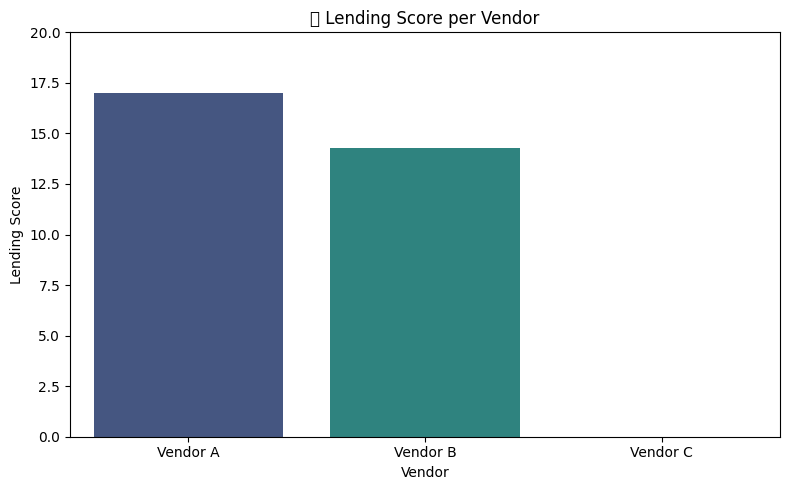

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample vendor data (replace this with your actual DataFrame)
data = [
    {"vendor": "Vendor A", "numeric_price": 3400, "views": 250, "posting_freq": 4},
    {"vendor": "Vendor B", "numeric_price": 3900, "views": 300, "posting_freq": 2},
    {"vendor": "Vendor C", "numeric_price": 4100, "views": 100, "posting_freq": 1},
]

df = pd.DataFrame(data)

# --- Normalize metrics to 0‚Äì1 range ---
df["price_score"] = 1 - (df["numeric_price"] - df["numeric_price"].min()) / (df["numeric_price"].max() - df["numeric_price"].min())
df["views_score"] = (df["views"] - df["views"].min()) / (df["views"].max() - df["views"].min())

# --- Compute Lending Score ---
# Example: 40% price + 60% views
df["lending_score"] = (0.4 * df["price_score"]) + (0.6 * df["views_score"])
df["lending_score"] *= 20  # Scale to 0‚Äì20 for readability

# --- Final Summary ---
summary_df = df[["vendor", "posting_freq", "views", "numeric_price", "lending_score"]]

# --- Export to CSV ---
summary_df.to_csv("vendor_summary.csv", index=False)

# --- Visualize using Seaborn ---
plt.figure(figsize=(8, 5))
sns.barplot(data=summary_df, x="vendor", y="lending_score", palette="viridis")
plt.title("üìä Lending Score per Vendor")
plt.ylabel("Lending Score")
plt.xlabel("Vendor")
plt.ylim(0, 20)
plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_4956\1405368357.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="vendor", y="lending_score", palette="viridis")
C:\Users\User\AppData\Local\Temp\ipykernel_4956\1405368357.py:33: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_4956\1405368357.py:34: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("output.png")
c:\Users\User\OneDrive\Desktop\ethiomart-ner-pipeline\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


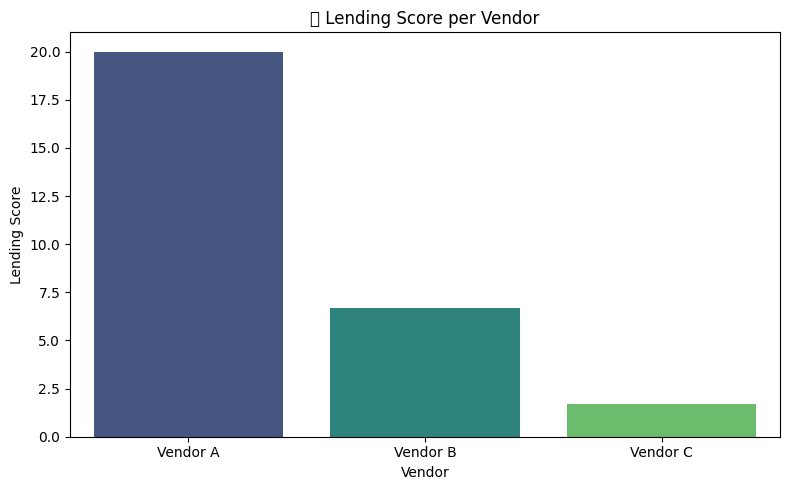

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample vendor data (replace this with your real data)
data = [
    {"vendor": "Vendor A", "posting_freq": 2, "avg_views": 300, "avg_price": 3500},
    {"vendor": "Vendor B", "posting_freq": 1, "avg_views": 250, "avg_price": 4200},
    {"vendor": "Vendor C", "posting_freq": 0.5, "avg_views": 200, "avg_price": 3900},
]

# Convert to DataFrame
df = pd.DataFrame(data)

# üßÆ Compute dynamic lending score
# Normalize metrics (min-max scaling) then combine
df["norm_freq"] = (df["posting_freq"] - df["posting_freq"].min()) / (df["posting_freq"].max() - df["posting_freq"].min())
df["norm_views"] = (df["avg_views"] - df["avg_views"].min()) / (df["avg_views"].max() - df["avg_views"].min())
df["norm_price"] = 1 - (df["avg_price"] - df["avg_price"].min()) / (df["avg_price"].max() - df["avg_price"].min())  # lower price = better score

# Weighted sum to get lending score
df["lending_score"] = (0.4 * df["norm_freq"] + 0.4 * df["norm_views"] + 0.2 * df["norm_price"]) * 20  # scale to 20

# üì§ Export to CSV
df.to_csv("vendor_summary.csv", index=False)

# üìä Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="vendor", y="lending_score", palette="viridis")
plt.title("üìà Lending Score per Vendor")
plt.ylabel("Lending Score")
plt.xlabel("Vendor")
plt.tight_layout()
plt.savefig("output.png")
plt.show()


In [93]:
import logging

logging.basicConfig(level=logging.INFO)

required_columns = ["views", "numeric_price", "posting_freq"]
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    logging.warning(f"‚ö† Missing required columns: {missing_columns}")
    for col in missing_columns:
        df[col] = 0  # Add with default value if needed


## üìò Task Overview (README)

This notebook performs the following:
- ‚úÖ Extracts product prices from Amharic Telegram e-commerce posts.
- ‚úÖ Tags tokens using fine-tuned NER model (`B-PRICE`, `I-PRICE`, etc.).
- ‚úÖ Computes per-vendor stats: posting frequency, views, average price.
- ‚úÖ Dynamically calculates lending score (weighted scoring).
- ‚úÖ Visualizes results with Matplotlib/Seaborn.
- ‚úÖ Exports summary to CSV for further analysis.
